In [3]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )

dir.create("pipeline/4.13.heart_failure", showWarnings = FALSE)


# Input CVPC + adult

In [4]:
metadata   =              fread("pipeline/3.1.covariates/metadata.txt"     , sep = "\t", header = TRUE , data.table = FALSE)
covariates = add_rownames(fread("pipeline/3.1.covariates/covariates.txt"   , sep = "\t", header = TRUE , data.table = FALSE))
int_list   = readLines         ("pipeline/3.2.eqtls/vars/cardiac_eqtls.txt")
#int_list   = int_list[grepl("^peer", int_list) == FALSE & grepl("^pc", int_list) == FALSE] # original
int_list   = c("sex", "total_reads_norm") # remove mitochondrial reads as covariate
covariates = covariates[,int_list]
gene_tpm   = add_rownames(fread("pipeline/1.2.expression/tpm_gene.normalized.txt"   , sep = "\t", header = TRUE , data.table = FALSE))
isof_tpm   = add_rownames(fread("pipeline/1.2.expression/tpm_isoform.normalized.txt", sep = "\t", header = TRUE , data.table = FALSE))
isof_use   = add_rownames(fread("pipeline/1.2.expression/use_isoform.normalized.txt", sep = "\t", header = TRUE , data.table = FALSE))


In [5]:

gene_info               = fread("input/phenotypes/gene_info.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
isof_info               = fread("input/phenotypes/isoform_info.txt", sep = "\t", header = TRUE, data.table = FALSE)
gene_info$transcript_id = gene_info$gene_id

diffgene = fread(paste("pipeline/4.1.differential_expression", "diffexp.txt"     , sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
diffcell = fread(paste("pipeline/4.1.differential_expression", "diffexp_cell.txt", sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)

diffgene$diffexp = FALSE
diffgene[diffgene$qval < 0.05, "diffexp"] = TRUE


# Input heart failure

In [6]:
meta4            = fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/input/phenotypes/SraRunTable_GSE46224.txt", sep = "\t", header = TRUE, data.table = FALSE)
colnames(meta4)  = tolower(gsub(" ", "_", colnames(meta4)))
meta4            = meta4[,c("run", "name", "age", "sex", "lvad_support")]
meta4$subject_id = gsub("_LVAD", "", meta4$name)

meta4 = meta4[!meta4$run %in% c("SRR830992", "SRR830976"),]

gene_tpm_hf   = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/1.2.expression/tpm_gene.expressed.txt"   , sep = "\t", header = TRUE , data.table = FALSE))
isof_use_hf   = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/1.2.expression/use_isoform.expressed.txt", sep = "\t", header = TRUE , data.table = FALSE))

gene_tpm_hf   = gene_tpm_hf[,meta4$run]
isof_use_hf   = isof_use_hf[,meta4$run]


# Differential expression heart failure

In [153]:
differential_expression_paired = function(disease, meta, expdata)
{
    if(disease == "all"){meta = meta[meta$lvad_support	 != "nil",]}
    if(disease != "all"){meta = meta[grepl(paste("^", disease, sep = ""), meta$subject_id) == TRUE, ]}
    
    expdata = expdata[rowSums(expdata) > 0,]
    
    meta1  = meta[meta$lvad_support == "pre-LVAD" , c("run", "subject_id")]
    meta2  = meta[meta$lvad_support == "Post-LVAD", c("run", "subject_id")]
    totest = merge(meta1, meta2, by = "subject_id", suffixes = c("_pre", "_post"))
    
    tests  = as.data.frame(rbindlist(lapply(rownames(expdata), function(x)
    {
        my_pre  = as.numeric(expdata[x, totest$run_pre])
        my_post = as.numeric(expdata[x, totest$run_post])
        this    = t.test(my_pre, my_post, paired = TRUE)
        out     = data.frame(transcript_id = x, 
                             mean_pre      = mean(my_pre), mean_pos = mean(my_post),
                             estimate = this$estimate, ci1 = this$conf.int[[1]], ci2 = this$conf.int[[2]], pval = this$p.value)
        return(out)
    })), stringsAsFactors = FALSE)
    
    tests$disease = disease
    tests$fdr     = p.adjust(tests$pval, method = "BH")
    
    return(tests)
}

disease = "ICM"

tests_gene = as.data.frame(rbindlist(lapply(c("ICM", "NICM", "all"), function(disease)
{
    out = differential_expression_paired(disease, meta4, gene_tpm_hf)
    out = merge(gene_info[, c("transcript_id", "gene_id", "gene_name")], out)
    
    return(out)
})), stringsAsFactors = FALSE)

tests_isof = as.data.frame(rbindlist(lapply(c("ICM", "NICM", "all"), function(disease)
{
    out = differential_expression_paired(disease, meta4, isof_use_hf)
    out = merge(isof_info[, c("transcript_id", "gene_id", "gene_name")], out)
    
    return(out)
})), stringsAsFactors = FALSE)


tests_gene = tests_gene[is.na(tests_gene$pval) == FALSE,]
tests_isof = tests_isof[is.na(tests_isof$pval) == FALSE,]

tests_gene$log2r = log2(tests_gene$mean_pre / tests_gene$mean_pos)
tests_isof$log2r = log2(tests_isof$mean_pre / tests_isof$mean_pos)

fwrite(tests_gene, "pipeline/4.13.heart_failure/diffexp_gene.txt"   , sep = "\t", col.names = TRUE, row.names = FALSE)
fwrite(tests_isof, "pipeline/4.13.heart_failure/diffexp_isoform.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [154]:
table(tests_gene[tests_gene$pval <= 0.05, "disease"])
table(tests_isof[tests_isof$pval <= 0.05, "disease"])



 all  ICM NICM 
1875 1946 2988 


 all  ICM NICM 
2679 2190 2105 

In [155]:
tissues  = unique(diffgene[,c("tissue1", "tissue2")])
diseases = c("ICM", "NICM", "all")

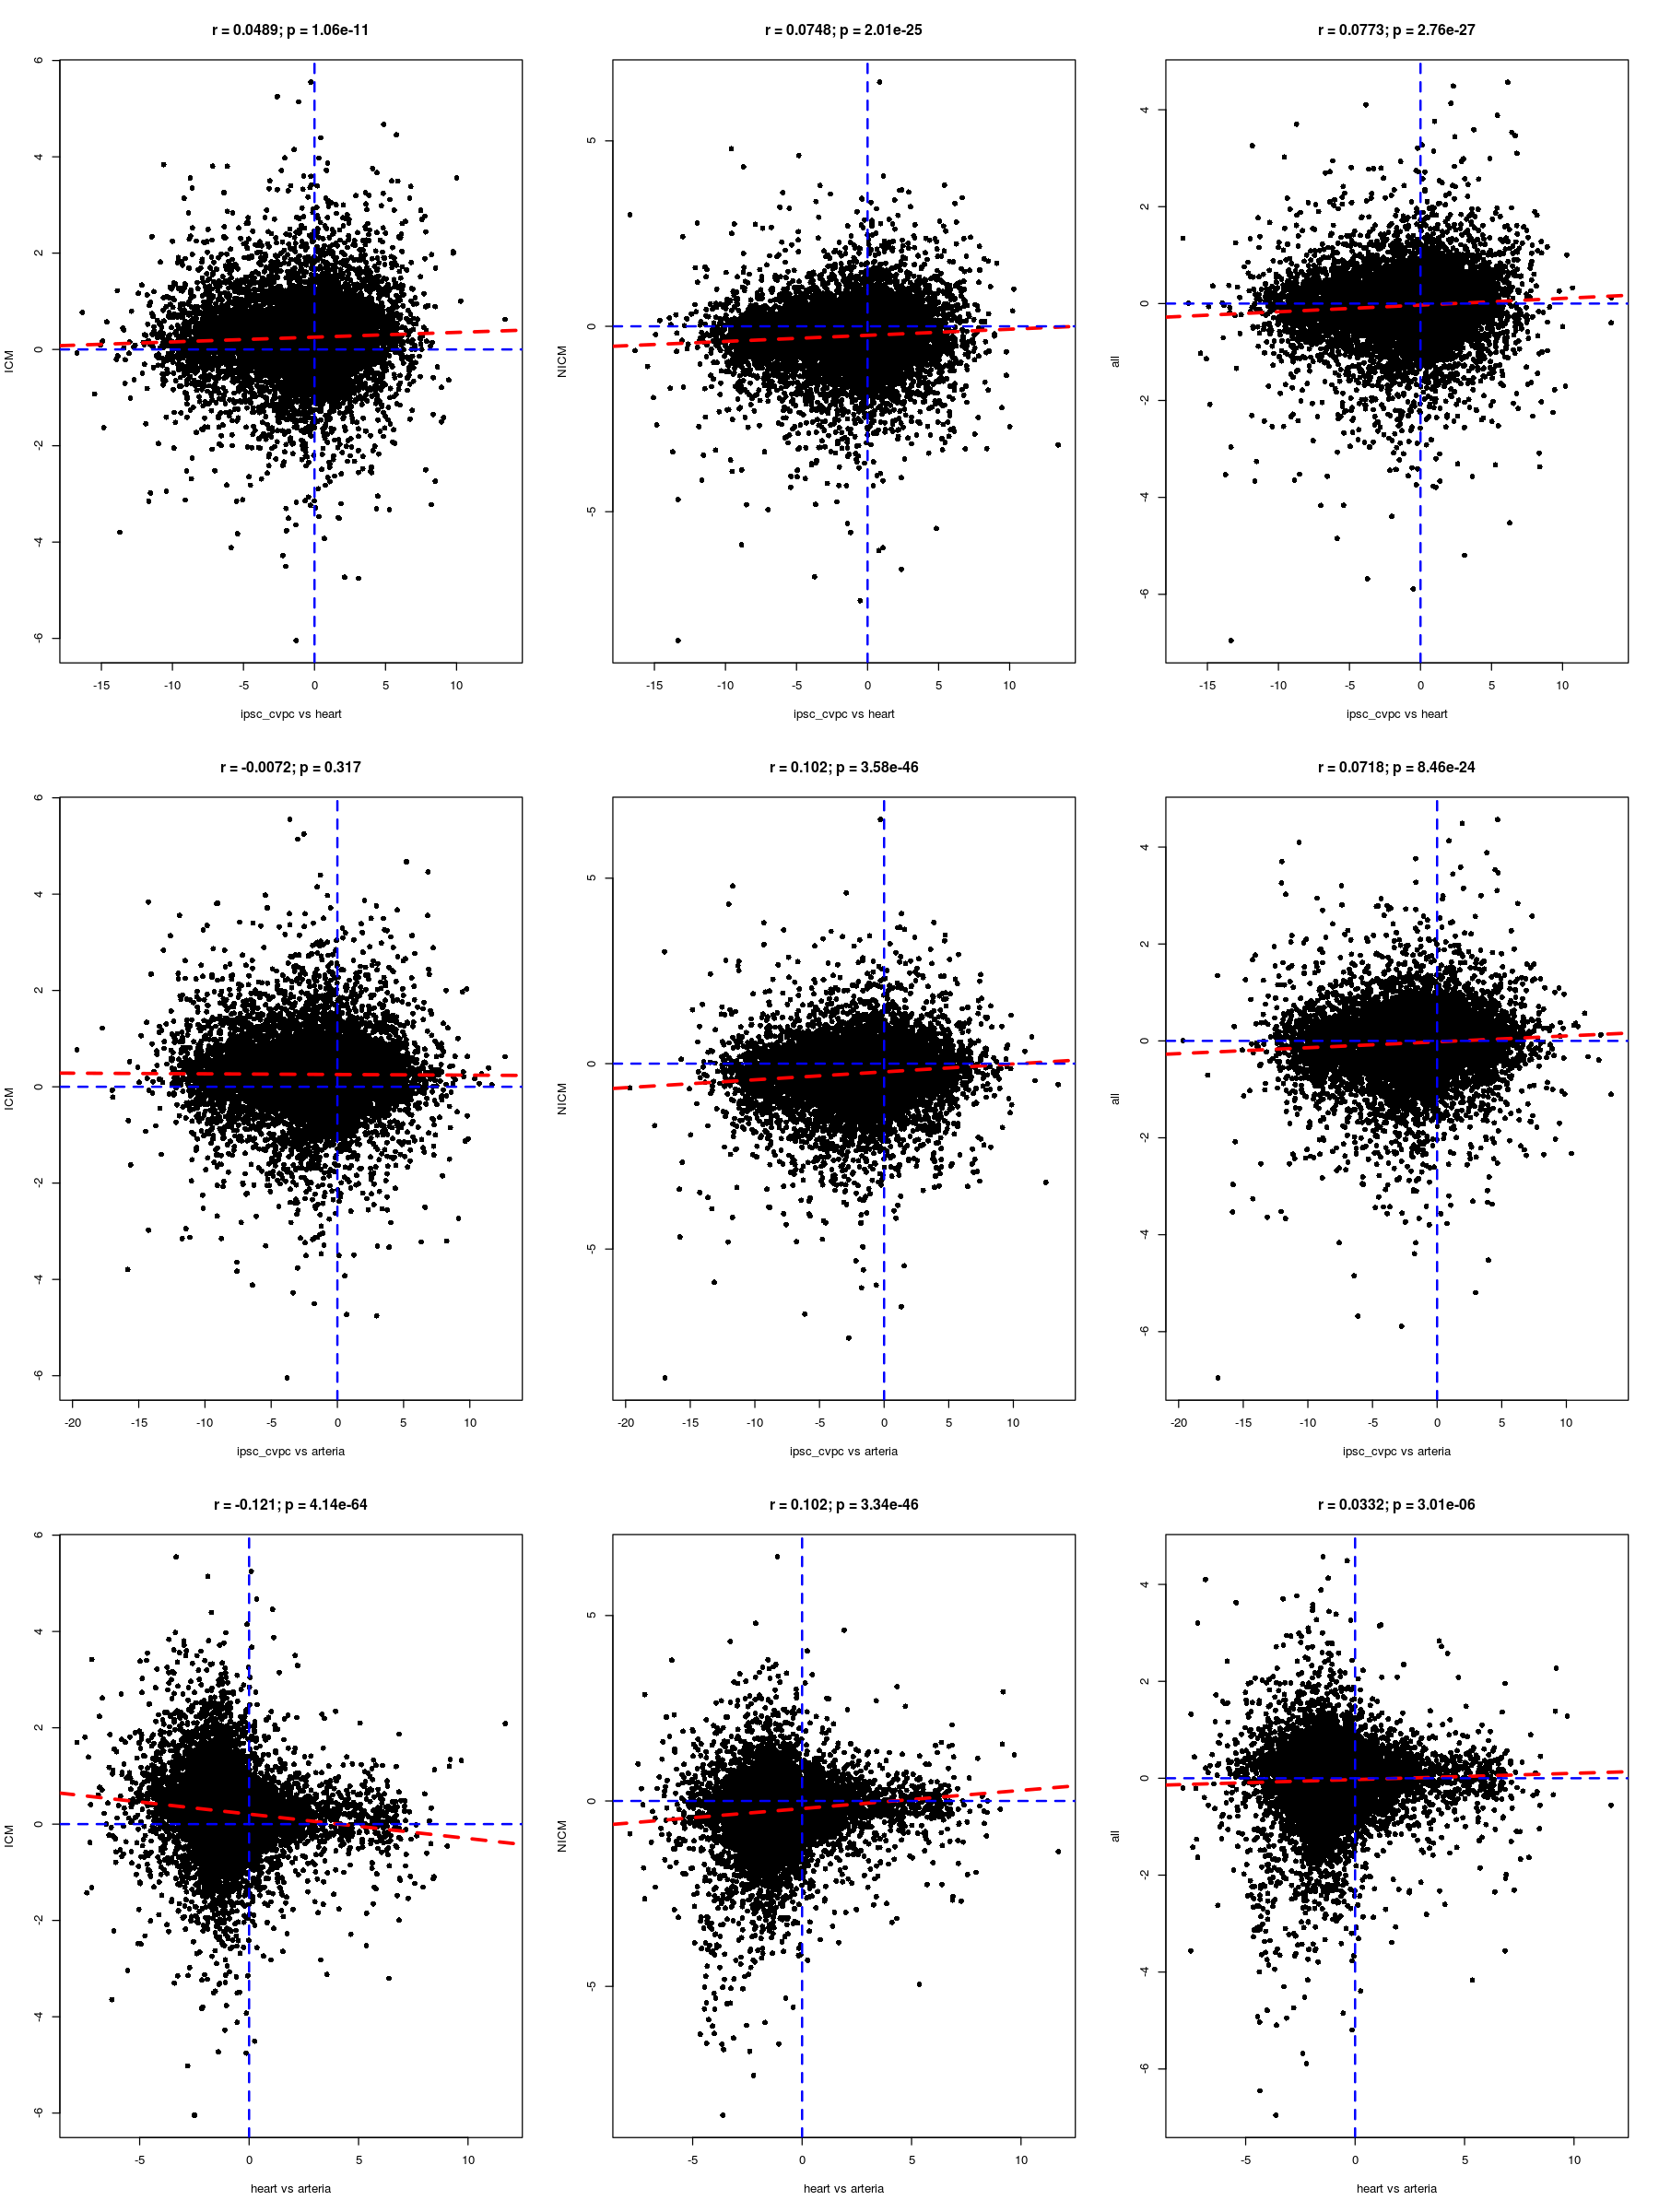

tissue1,tissue2,disease,cor,pval,type
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
ipsc_cvpc,heart,ICM,0.048914882,1.060482e-11,gene_tpm
ipsc_cvpc,heart,NICM,0.074784592,2.009469e-25,gene_tpm
ipsc_cvpc,heart,all,0.077262806,2.763847e-27,gene_tpm
ipsc_cvpc,arteria,ICM,-0.007198924,3.173593e-01,gene_tpm
ipsc_cvpc,arteria,NICM,0.102260517,3.575895e-46,gene_tpm
ipsc_cvpc,arteria,all,0.071836336,8.457616e-24,gene_tpm
heart,arteria,ICM,-0.120501609,4.137741e-64,gene_tpm
heart,arteria,NICM,0.101623470,3.337340e-46,gene_tpm
heart,arteria,all,0.033151983,3.013607e-06,gene_tpm


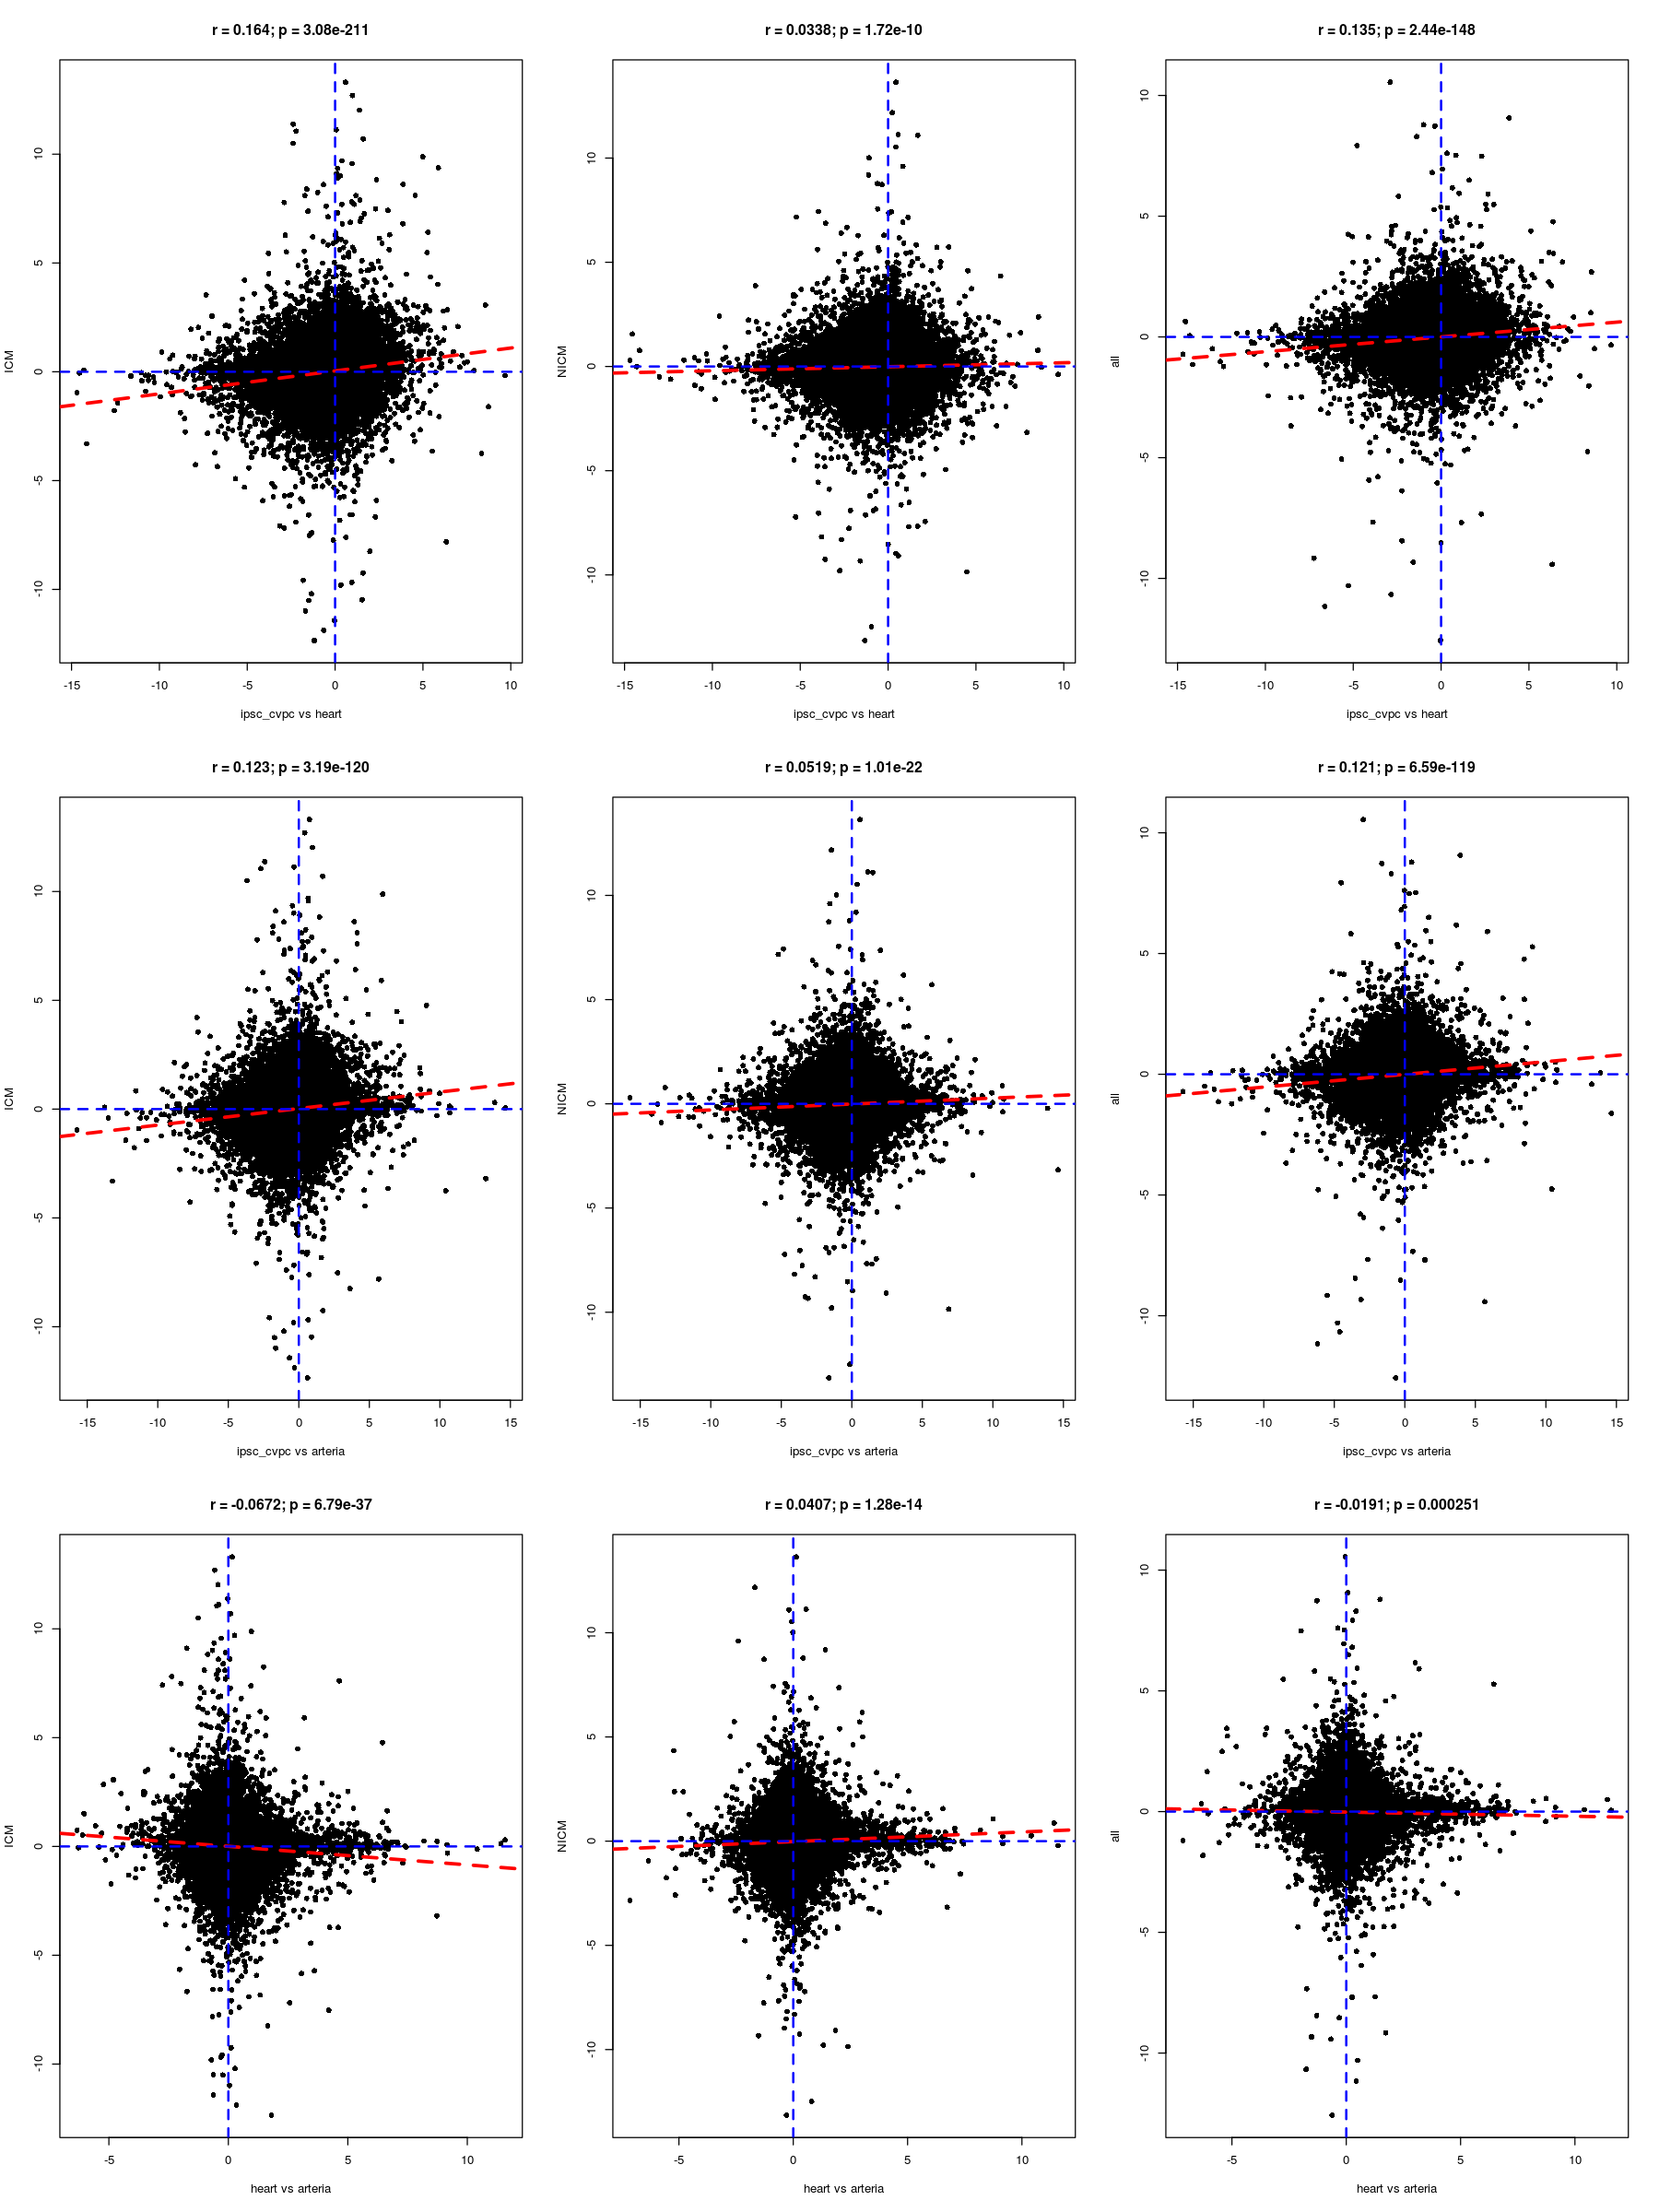

In [156]:
plot_cor = function(dif1, dif2, tissue1, tissue2, disease)
{
    dif1 = dif1[dif1$tissue1 == tissue1 & dif1$tissue2 == tissue2, c("transcript_id", "gene_id", "gene_name", "log2r", "pval", "qval")]
    dif2 = dif2[dif2$disease == disease, c("transcript_id", "log2r", "pval")]
    
    indata = merge(dif1, dif2, by = "transcript_id", suffixes = 1:2)
    indata = indata[ is.infinite(indata$log2r1) == FALSE & is.infinite(indata$log2r2) == FALSE, ]
    
    #message(paste(tissue1, tissue2, disease, nrow(indata)))
    
    mycor  = cor.test(indata$log2r1, indata$log2r2)
    #message(paste(tissue1, tissue2, disease, signif(mycor$estimate), signif(mycor$p.value)))
    
    plot(indata$log2r1, indata$log2r2, pch = 16, xlab = paste(tissue1, "vs", tissue2), ylab = disease, main = paste("r = ", signif(mycor$estimate, digits = 3), "; p = ", signif(mycor$p.value, digits = 3), sep = ""))
    
    if(nrow(indata) < 200)
    {
        text(x = indata$log2r1, y = indata$log2r2, labels = indata$gene_name, font = 3)
    }
    
    abline(lm(log2r2 ~ log2r1, data = indata), col = "#ff0000", lty = "dashed", lwd = 3)
    abline(h = 0, col = "#0000ff", lty = "dashed", lwd = 2)
    abline(v = 0, col = "#0000ff", lty = "dashed", lwd = 2)
    return(data.frame(tissue1 = tissue1, tissue2 = tissue2, disease = disease, cor = mycor$estimate, pval = mycor$p.value))
}

options(repr.plot.width = 15, repr.plot.height = 20)
layout(matrix(1:9, nrow = 3, byrow = TRUE))


tissue1 = "ipsc_cvpc"
tissue2 = "heart"
disease = "ICM"

cortests_gene = as.data.frame(rbindlist(lapply(1:nrow(tissues), function(ii)
{
    tissue1 = tissues[ii, "tissue1"]
    tissue2 = tissues[ii, "tissue2"]
    out     = as.data.frame(rbindlist(lapply(diseases, function(disease)
    {
        plot_cor(diffgene[diffgene$type == "gene_tpm",], tests_gene, tissue1, tissue2, disease)
    })), stringsAsFactors = FALSE)
    
    return(out)
})), stringsAsFactors = FALSE)

cortests_gene$type = "gene_tpm"

cortests_isof = as.data.frame(rbindlist(lapply(1:nrow(tissues), function(ii)
{
    tissue1 = tissues[ii, "tissue1"]
    tissue2 = tissues[ii, "tissue2"]
    out     = as.data.frame(rbindlist(lapply(diseases, function(disease)
    {
        plot_cor(diffgene[diffgene$type == "isoform_use",], tests_isof, tissue1, tissue2, disease)
    })), stringsAsFactors = FALSE)
    
    return(out)
})), stringsAsFactors = FALSE)

cortests_gene$type = "gene_tpm"
cortests_isof$type = "isoform_use"

cortests = rbind(cortests_gene, cortests_isof)

cortests


# RBPs

In [157]:
rbps = readLines("pipeline/rbps.txt")

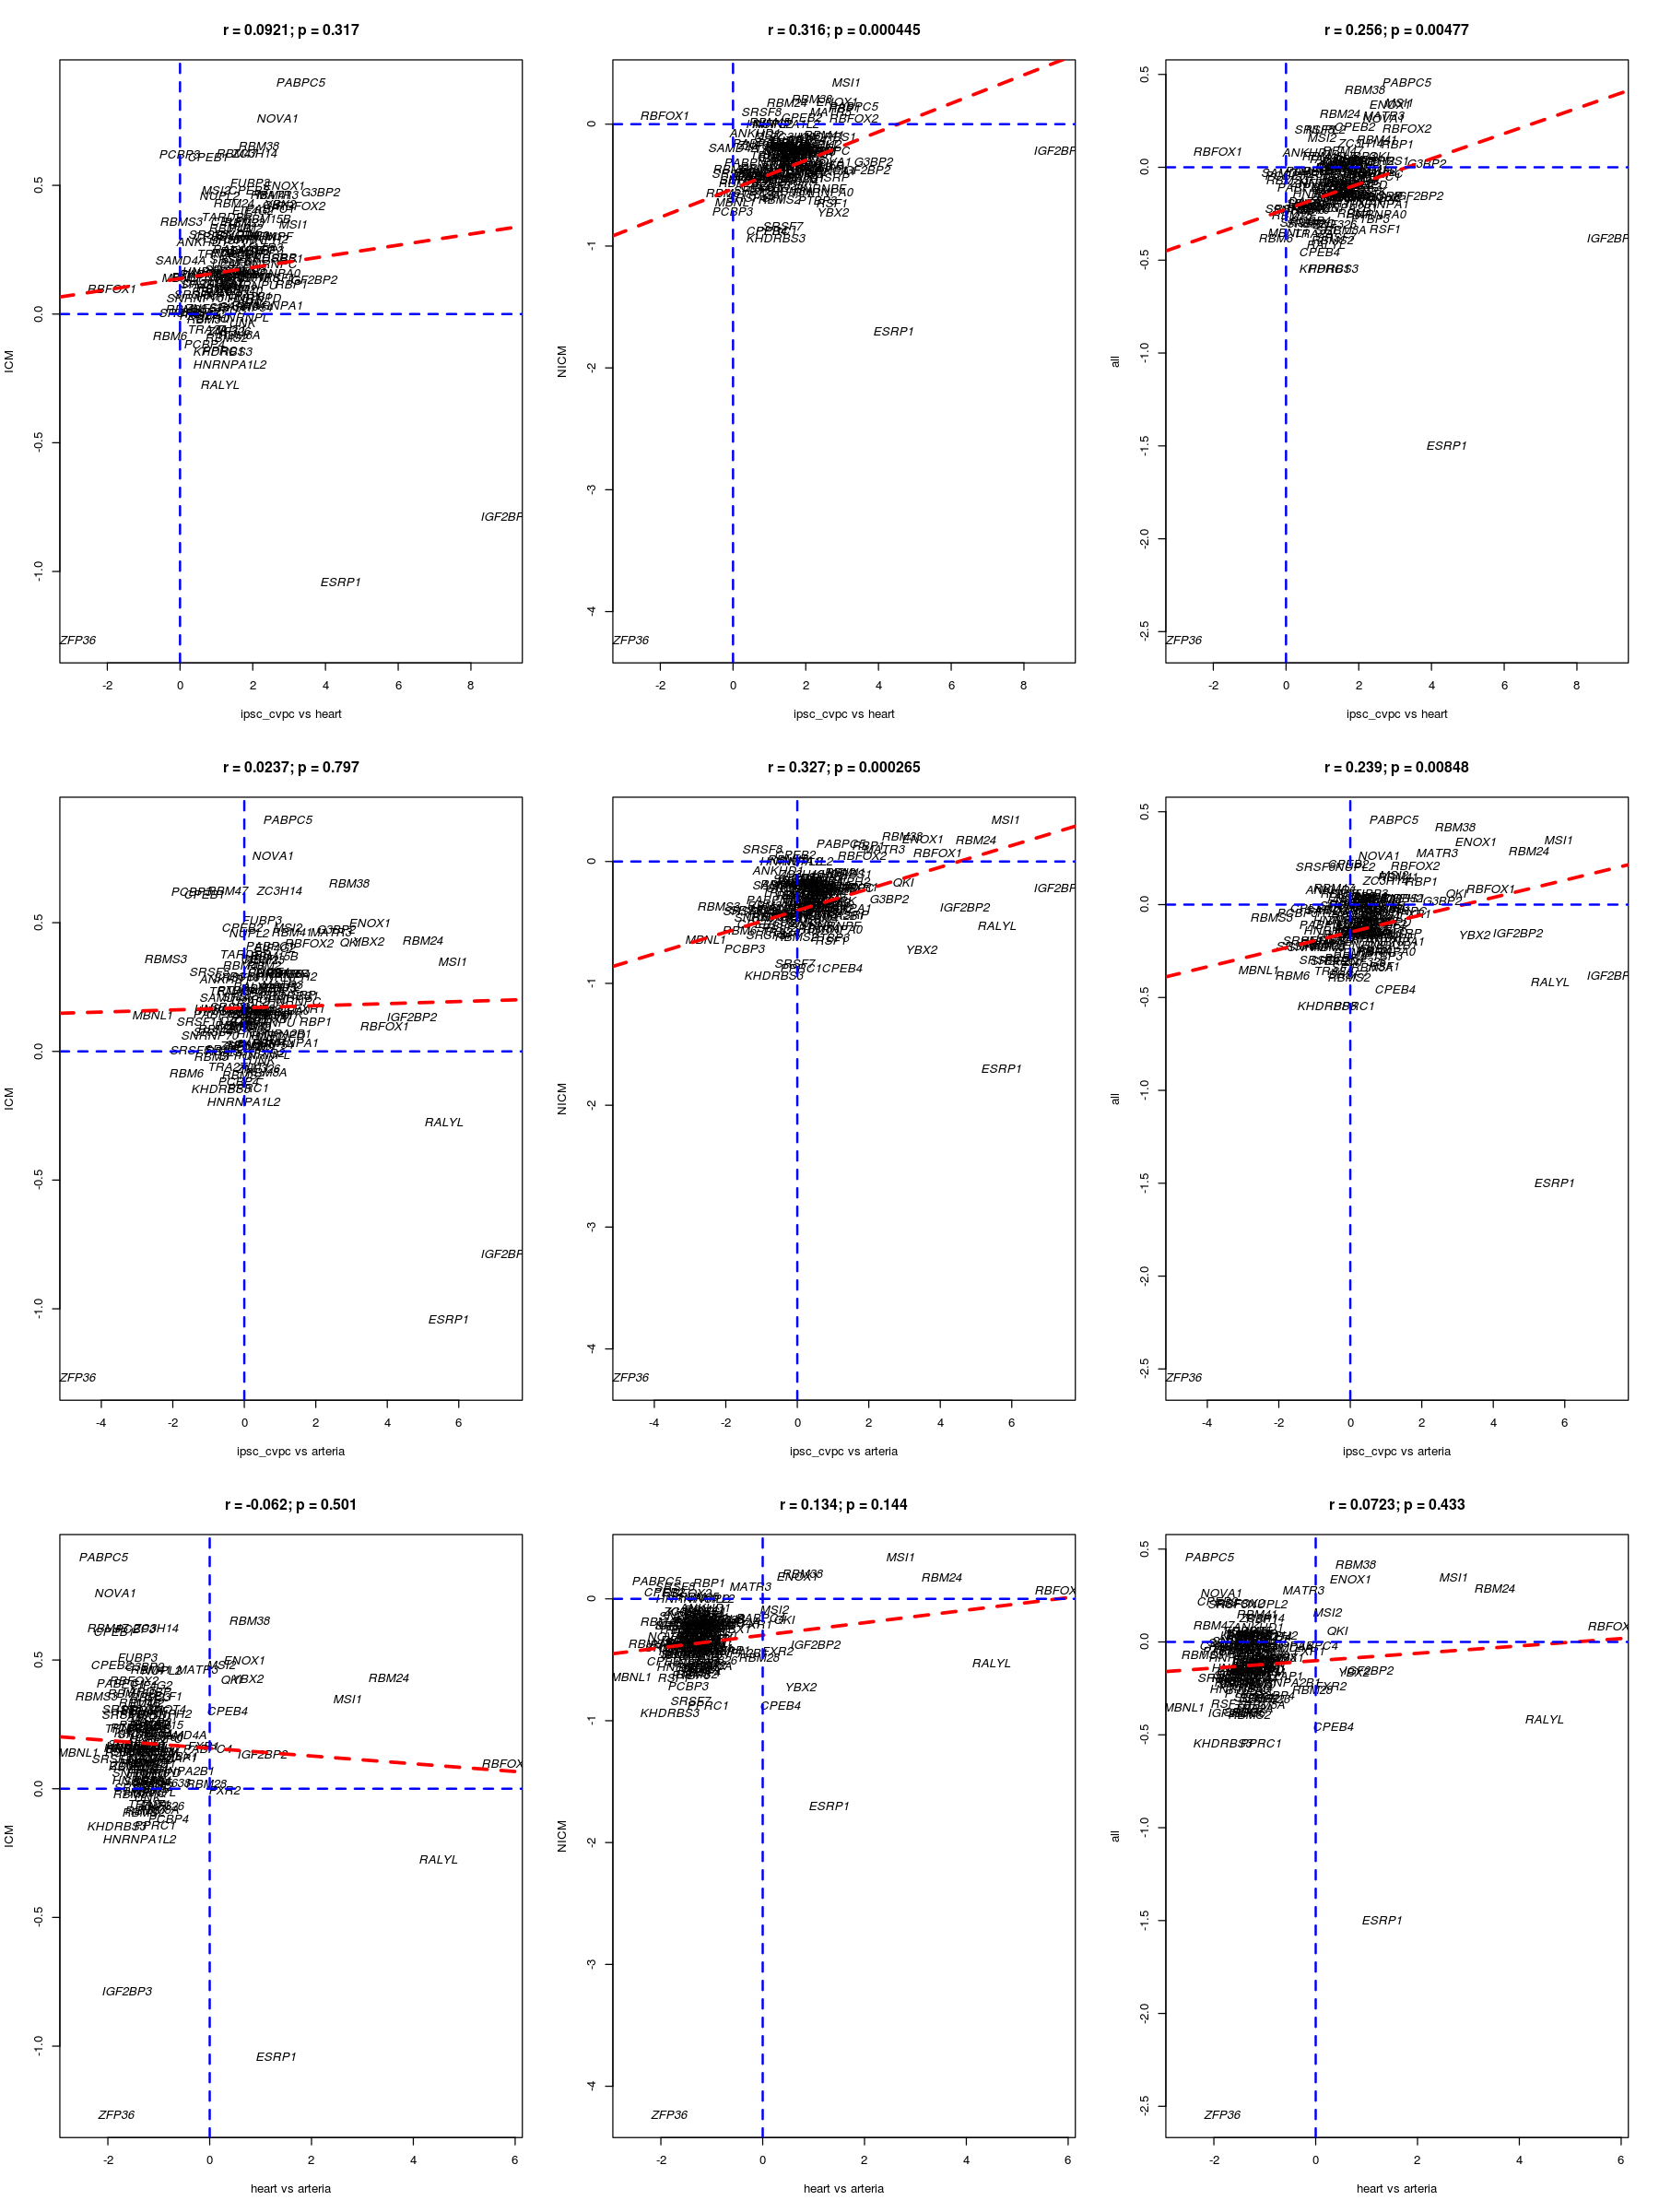

tissue1,tissue2,disease,cor,pval,type
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
ipsc_cvpc,heart,ICM,0.09207844,3.171954e-01,gene_tpm
ipsc_cvpc,heart,NICM,0.31565093,4.450553e-04,gene_tpm
ipsc_cvpc,heart,all,0.25598455,4.772542e-03,gene_tpm
ipsc_cvpc,arteria,ICM,0.02367385,7.974447e-01,gene_tpm
ipsc_cvpc,arteria,NICM,0.32712435,2.655000e-04,gene_tpm
ipsc_cvpc,arteria,all,0.23931043,8.477364e-03,gene_tpm
heart,arteria,ICM,-0.06197660,5.012907e-01,gene_tpm
heart,arteria,NICM,0.13428720,1.436653e-01,gene_tpm
heart,arteria,all,0.07228060,4.327271e-01,gene_tpm


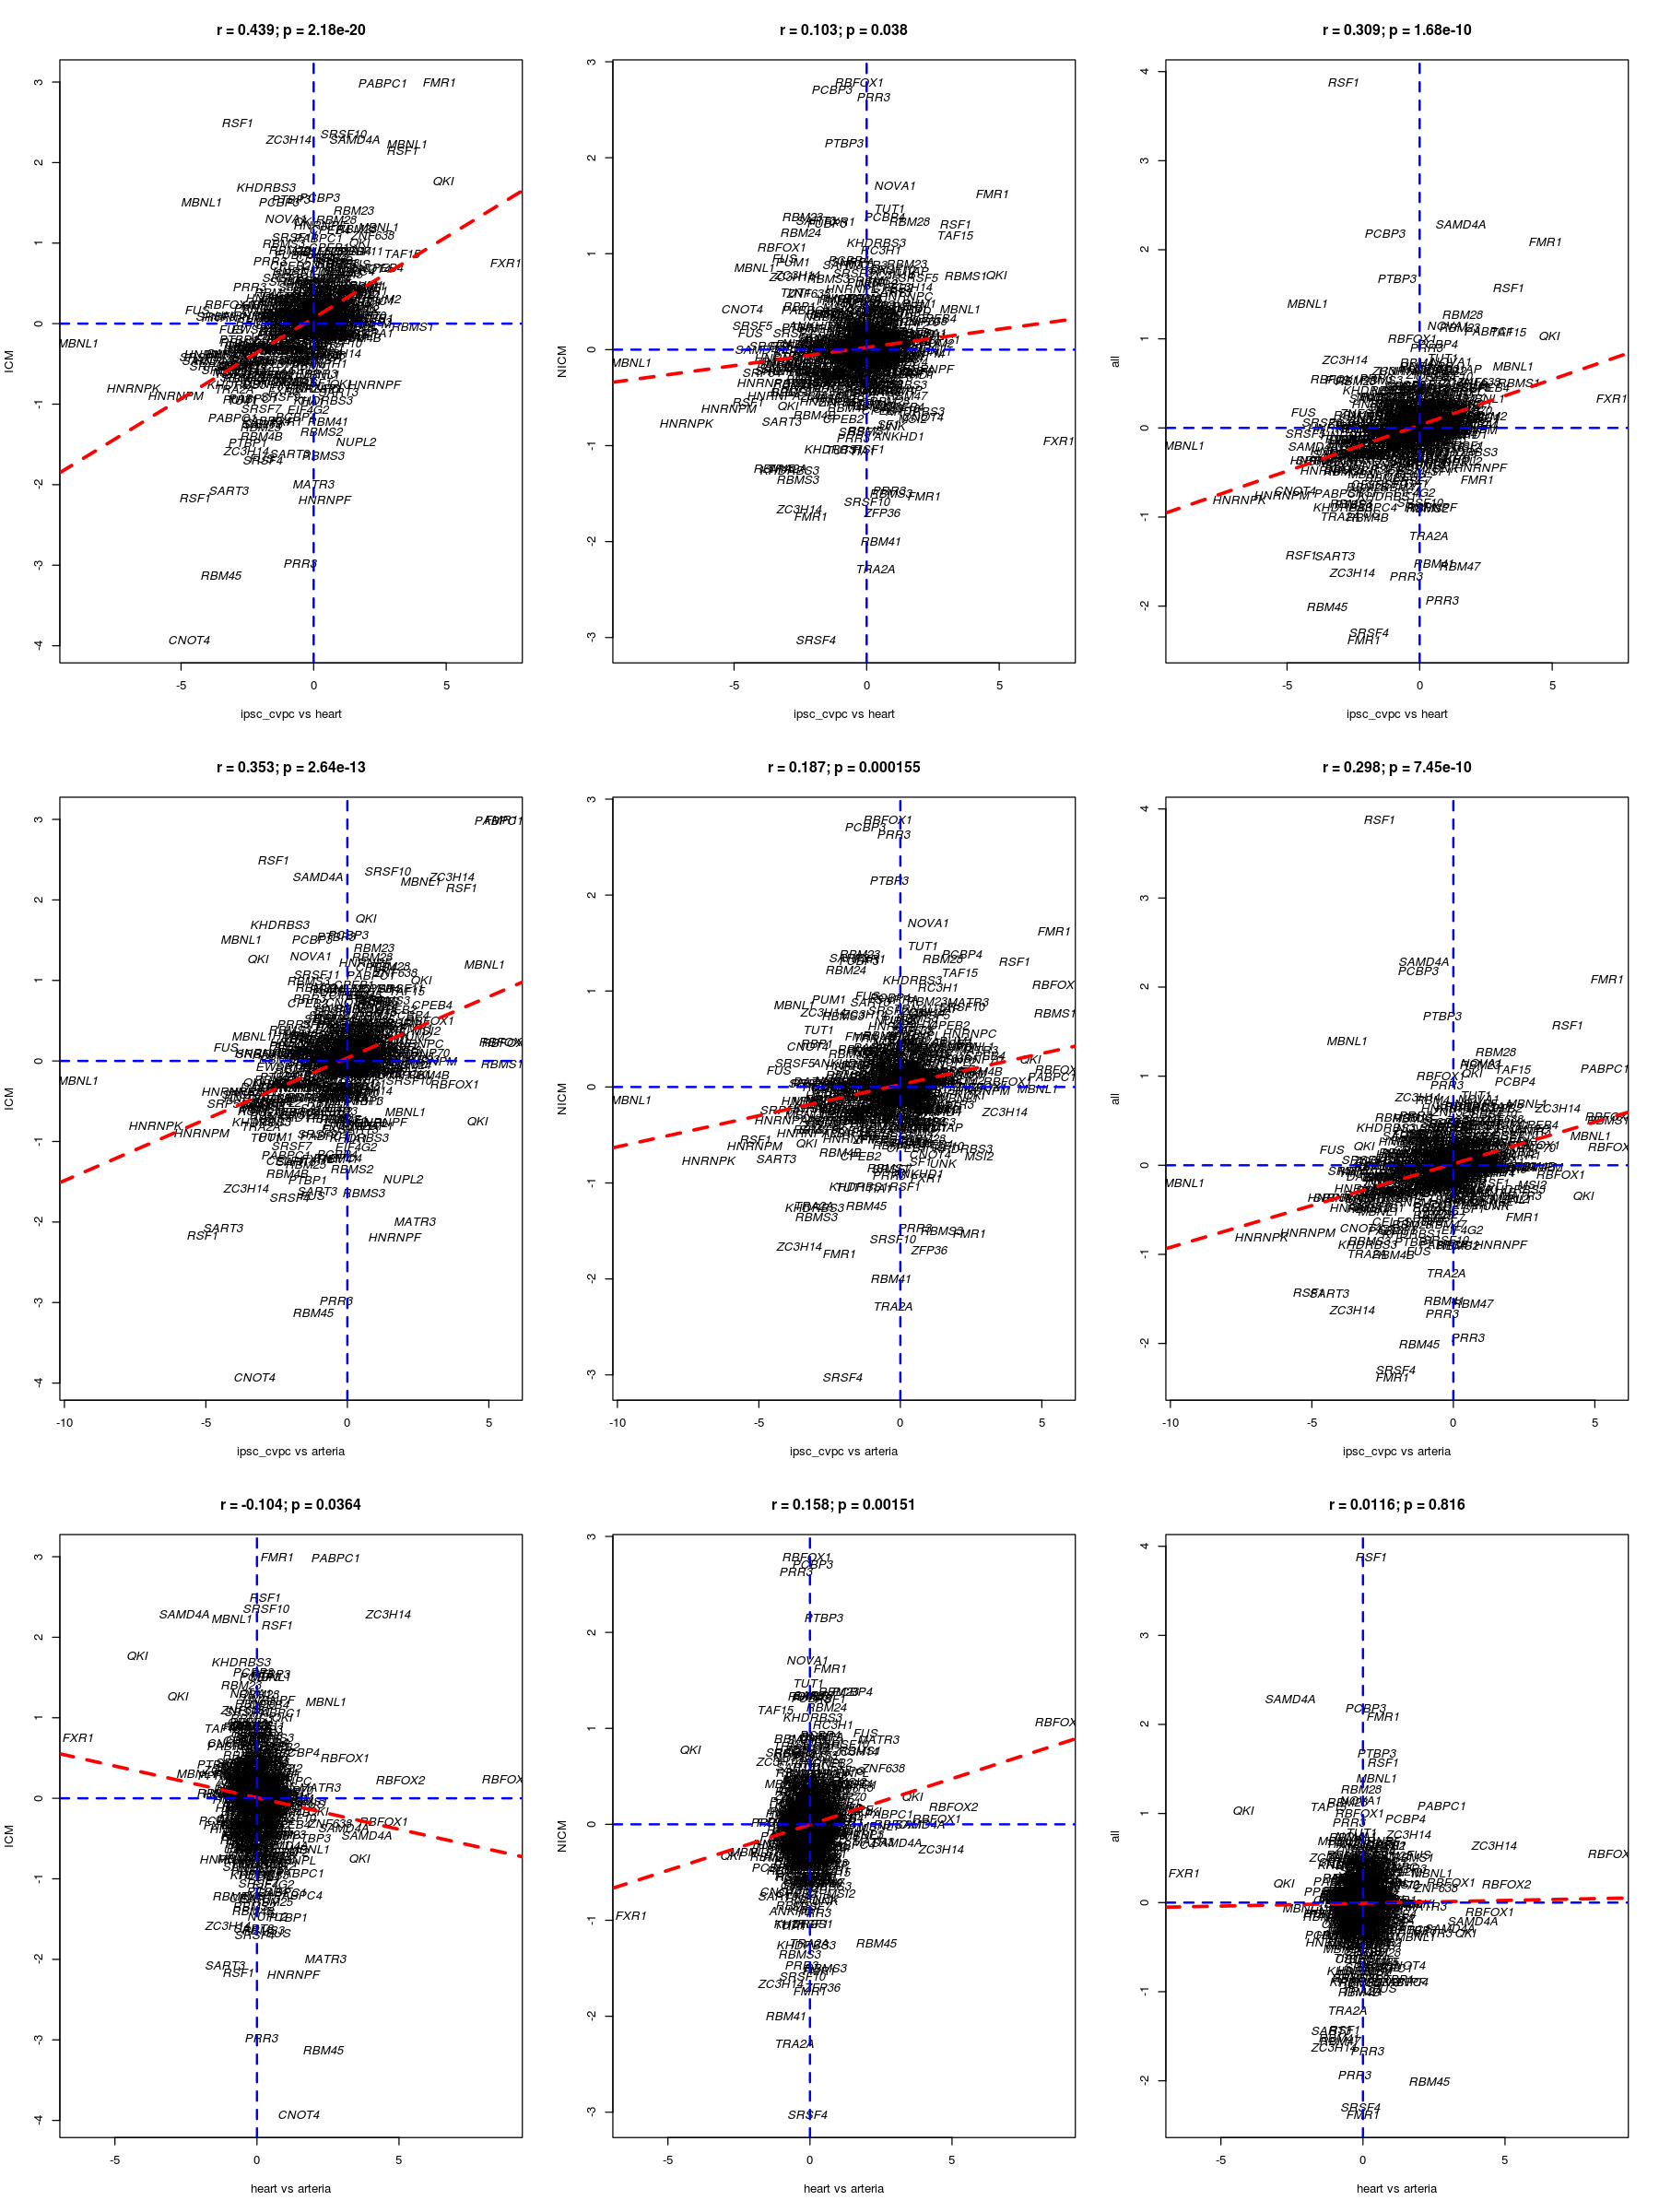

In [158]:
plot_cor2 = function(dif1, dif2, tissue1, tissue2, disease)
{
    dif1 = dif1[dif1$tissue1 == tissue1 & dif1$tissue2 == tissue2, c("transcript_id", "gene_id", "gene_name", "log2r", "pval", "qval")]
    dif2 = dif2[dif2$disease == disease, c("transcript_id", "log2r", "pval")]
    
    indata = merge(dif1, dif2, by = "transcript_id", suffixes = 1:2)
    indata = indata[ is.infinite(indata$log2r1) == FALSE & is.infinite(indata$log2r2) == FALSE, ]
    
    #message(paste(tissue1, tissue2, disease, nrow(indata)))
    
    mycor  = cor.test(indata$log2r1, indata$log2r2)
    #message(paste(tissue1, tissue2, disease, signif(mycor$estimate), signif(mycor$p.value)))
    
    plot(indata$log2r1, indata$log2r2, type = "n", pch = 16, xlab = paste(tissue1, "vs", tissue2), ylab = disease, main = paste("r = ", signif(mycor$estimate, digits = 3), "; p = ", signif(mycor$p.value, digits = 3), sep = ""))
    
    text(x = indata$log2r1, y = indata$log2r2, labels = indata$gene_name, font = 3)
    
    abline(lm(log2r2 ~ log2r1, data = indata), col = "#ff0000", lty = "dashed", lwd = 3)
    abline(h = 0, col = "#0000ff", lty = "dashed", lwd = 2)
    abline(v = 0, col = "#0000ff", lty = "dashed", lwd = 2)
    return(data.frame(tissue1 = tissue1, tissue2 = tissue2, disease = disease, cor = mycor$estimate, pval = mycor$p.value))
}

options(repr.plot.width = 15, repr.plot.height = 20)
layout(matrix(1:9, nrow = 3, byrow = TRUE))

rbptests_gene = as.data.frame(rbindlist(lapply(1:nrow(tissues), function(ii)
{
    tissue1 = tissues[ii, "tissue1"]
    tissue2 = tissues[ii, "tissue2"]
    out     = as.data.frame(rbindlist(lapply(diseases, function(disease)
    {
        plot_cor2(diffgene[diffgene$type == "gene_tpm" & diffgene$gene_name %in% rbps,], tests_gene, tissue1, tissue2, disease)
    })), stringsAsFactors = FALSE)
    
    return(out)
})), stringsAsFactors = FALSE)

rbptests_gene$type = "gene_tpm"

rbptests_isof = as.data.frame(rbindlist(lapply(1:nrow(tissues), function(ii)
{
    tissue1 = tissues[ii, "tissue1"]
    tissue2 = tissues[ii, "tissue2"]
    out     = as.data.frame(rbindlist(lapply(diseases, function(disease)
    {
        plot_cor2(diffgene[diffgene$type == "isoform_use" & diffgene$gene_name %in% rbps,], tests_isof, tissue1, tissue2, disease)
    })), stringsAsFactors = FALSE)
    
    return(out)
})), stringsAsFactors = FALSE)

rbptests_gene$type = "gene_tpm"
rbptests_isof$type = "isoform_use"
rbptests           = rbind(rbptests_gene, rbptests_isof)
rbptests


In [162]:
fisher.test(matrix(c(14,1, 1, 14), nrow = 2, byrow = TRUE))


	Fisher's Exact Test for Count Data

data:  matrix(c(14, 1, 1, 14), nrow = 2, byrow = TRUE)
p-value = 2.914e-06
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
    8.668184 8055.294653
sample estimates:
odds ratio 
   121.768 


# Write output with RBPs

In [358]:
merge_difs = function(dif1, dif2, tissue1, tissue2, disease)
{
    dif1 = dif1[dif1$tissue1 == tissue1 & dif1$tissue2 == tissue2, c("tissue1", "tissue2", "transcript_id", "gene_id", "gene_name", "log2r", "pval", "qval")]
    dif2 = dif2[dif2$disease == disease, c("disease", "transcript_id", "log2r", "pval", "fdr")]
    
    indata = merge(dif1, dif2, by = "transcript_id", suffixes = 1:2)
    indata = indata[ is.infinite(indata$log2r1) == FALSE & is.infinite(indata$log2r2) == FALSE, ]

    return(indata)
}

options(repr.plot.width = 15, repr.plot.height = 20)
layout(matrix(1:9, nrow = 3, byrow = TRUE))


tissue1 = "ipsc_cvpc"
tissue2 = "heart"
disease = "ICM"

merge_gene = as.data.frame(rbindlist(lapply(1:nrow(tissues), function(ii)
{
    tissue1 = tissues[ii, "tissue1"]
    tissue2 = tissues[ii, "tissue2"]
    out     = as.data.frame(rbindlist(lapply(diseases, function(disease)
    {
        merge_difs(diffgene[diffgene$type == "gene_tpm",], tests_gene, tissue1, tissue2, disease)
    })), stringsAsFactors = FALSE)
    
    return(out)
})), stringsAsFactors = FALSE)

merge_gene$type = "gene_tpm"

merge_isof = as.data.frame(rbindlist(lapply(1:nrow(tissues), function(ii)
{
    tissue1 = tissues[ii, "tissue1"]
    tissue2 = tissues[ii, "tissue2"]
    out     = as.data.frame(rbindlist(lapply(diseases, function(disease)
    {
        merge_difs(diffgene[diffgene$type == "isoform_use",], tests_isof, tissue1, tissue2, disease)
    })), stringsAsFactors = FALSE)
    
    return(out)
})), stringsAsFactors = FALSE)

merge_gene$type = "gene_tpm"
merge_isof$type = "isoform_use"

exp2hf     = rbind(merge_gene, merge_isof)
exp2hf$rbp = FALSE
exp2hf[exp2hf$gene_name %in% rbps, "rbp"] = TRUE

fwrite(exp2hf, "pipeline/4.13.heart_failure/diffexp_vs_heart_failure.txt"   , sep = "\t", col.names = TRUE, row.names = FALSE)



In [359]:
str(exp2hf)


'data.frame':	499501 obs. of  14 variables:
 $ transcript_id: chr  "ENSG00000000003.15_5" "ENSG00000000005.6_4" "ENSG00000000419.12_6" "ENSG00000000457.14_7" ...
 $ tissue1      : chr  "ipsc_cvpc" "ipsc_cvpc" "ipsc_cvpc" "ipsc_cvpc" ...
 $ tissue2      : chr  "heart" "heart" "heart" "heart" ...
 $ gene_id      : chr  "ENSG00000000003.15_5" "ENSG00000000005.6_4" "ENSG00000000419.12_6" "ENSG00000000457.14_7" ...
 $ gene_name    : chr  "TSPAN6" "TNMD" "DPM1" "SCYL3" ...
 $ log2r1       : num  3.77 4.04 1.13 1.39 1.61 ...
 $ pval1        : num  1.48e-54 1.35e-50 7.27e-06 1.58e-39 1.20e-47 ...
 $ qval         : num  3.01e-50 2.75e-46 1.48e-01 3.21e-35 2.45e-43 ...
 $ disease      : chr  "ICM" "ICM" "ICM" "ICM" ...
 $ log2r2       : num  0.0289 -0.4524 0.2571 0.3464 -0.0533 ...
 $ pval2        : num  0.918 0.725 0.173 0.357 0.901 ...
 $ fdr          : num  0.966 0.872 0.568 0.661 0.957 ...
 $ type         : chr  "gene_tpm" "gene_tpm" "gene_tpm" "gene_tpm" ...
 $ rbp          : logi  FALSE FA

# Interesting genes/isoforms

In [367]:
a = exp2hf[exp2hf$fdr <= 0.1 & exp2hf$qval <= 0.05& exp2hf$disease == "all" & exp2hf$tissue1 == "ipsc_cvpc" & exp2hf$tissue2 == "heart" & sign(exp2hf$log2r1) != sign(exp2hf$log2r2),]

a[order(a$pval2),]

,transcript_id,tissue1,tissue2,gene_id,gene_name,log2r1,pval1,qval,disease,log2r2,pval2,fdr,type,rbp
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
56556,ENSG00000268292.1_8,ipsc_cvpc,heart,ENSG00000268292.1_8,AC006547.3,-11.35805347,2.508543e-94,5.115671e-90,all,0.5534264,2.788571e-07,0.002806697,gene_tpm,FALSE
57754,ENSG00000280219.1_6,ipsc_cvpc,heart,ENSG00000280219.1_6,AC093908.1,2.75913599,5.248263e-33,1.070278e-28,all,-0.9333290,6.603248e-07,0.004430779,gene_tpm,FALSE
56369,ENSG00000267034.1_7,ipsc_cvpc,heart,ENSG00000267034.1_7,AC010980.2,3.09203578,1.310918e-52,2.673355e-48,all,-2.0380186,1.421009e-05,0.026004465,gene_tpm,FALSE
41694,ENSG00000107859.10_5,ipsc_cvpc,heart,ENSG00000107859.10_5,PITX3,0.76296291,1.071996e-17,2.186122e-13,all,-2.8092217,1.781131e-05,0.029684321,gene_tpm,FALSE
48838,ENSG00000168209.5_5,ipsc_cvpc,heart,ENSG00000168209.5_5,DDIT4,0.01391183,4.040831e-15,8.240467e-11,all,-1.7162163,1.920956e-05,0.029684321,gene_tpm,FALSE
50897,ENSG00000183597.16_4,ipsc_cvpc,heart,ENSG00000183597.16_4,TANGO2,-1.39706969,1.030893e-88,2.102299e-84,all,0.5295977,4.145106e-05,0.042308362,gene_tpm,FALSE
47905,ENSG00000163659.13_5,ipsc_cvpc,heart,ENSG00000163659.13_5,TIPARP,2.01361802,6.173453e-07,1.258952e-02,all,-1.6037590,7.416131e-05,0.057417967,gene_tpm,FALSE
45927,ENSG00000144476.6_5,ipsc_cvpc,heart,ENSG00000144476.6_5,ACKR3,-0.37430582,1.562801e-33,3.187019e-29,all,0.9814253,8.745419e-05,0.065201958,gene_tpm,FALSE
50932,ENSG00000183779.7_4,ipsc_cvpc,heart,ENSG00000183779.7_4,ZNF703,1.64578284,9.315734e-12,1.899758e-07,all,-1.1673688,1.113569e-04,0.069849559,gene_tpm,FALSE


# PCA on RBPs
- like figure 1b, only RBPs and using all samples (also RBPs): try gene expression and isoform expression

In [60]:
metadata = metadata[metadata$tissue %in% c("ipsc_cvpc", "heart"),]

In [61]:
library(Seurat)

In [62]:
load("/home/jennifer/projects/cardiac_eqtls/3.Clustering/results/heart_failure_integrated.robj")
load("/home/jennifer/projects/cardiac_eqtls/4.Heart_Failure/results/heart_failure.heart_cvpc.RBPs_only.robj")


In [63]:
pcdata = integrated@meta.data

eigs <- integrated@reductions$pca@stdev^2
eigs[1] / sum(eigs) * 100
eigs[2] / sum(eigs) * 100
sum(eigs[1:10] / sum(eigs) * 100)


[1] 54.81199

[1] 11.41296

[1] 86.64018

In [68]:
mat <- Seurat::GetAssayData(integrated, assay = "RNA", slot = "scale.data")
pca <- integrated[["pca"]]

# Get the total variance:
total_variance <- sum(matrixStats::rowVars(mat))

eigValues = (pca@stdev)^2  ## EigenValues
varExplained = eigValues / total_variance

In [73]:
str(mat)

 num[0 , 0 ] 


In [28]:
alldist = as.matrix(dist(as.matrix(pcdata[, paste("PC", 1:10, sep = "_")]), method = "euclidean"))

## Distance from iPSC-CVPCs and adult

In [30]:
calculate_mean_distance = function(x, id, metadata, alldist)
{
    ids    = metadata[metadata$tissue == x, "run"]
    mydist = as.numeric(alldist[ids, id])
    
    return(median(mydist))
}

hf2dist           = meta4[ meta4$lvad_support != "nil",]
rownames(hf2dist) = hf2dist$run

id = rownames(hf2dist)[[1]]
x = "ipsc_cvpc"

for(tissue in sort(unique(metadata$tissue)))
#for(tissue in c("ipsc_cvpc", "heart"))
{
    hf2dist[, paste("dist", tissue, sep = ".")] = unlist(lapply(rownames(hf2dist), function(id){calculate_mean_distance(tissue, id, metadata, alldist)}))
}


fwrite(hf2dist, "pipeline/4.13.heart_failure/hf2dist.txt", sep = "\t", col.names = TRUE, row.names = FALSE)
fwrite(pcdata , "pipeline/4.13.heart_failure/pcdata.txt" , sep = "\t", col.names = TRUE, row.names = TRUE )


In [31]:
source("script/colors.R"    )


ipsc_cvpc 14.3838247889752 21.4908324081818 7.10700761920659 1.29538982411188e-06

heart 14.7429611331545 10.1717996495906 -4.5711614835639 2.7297523059529e-08



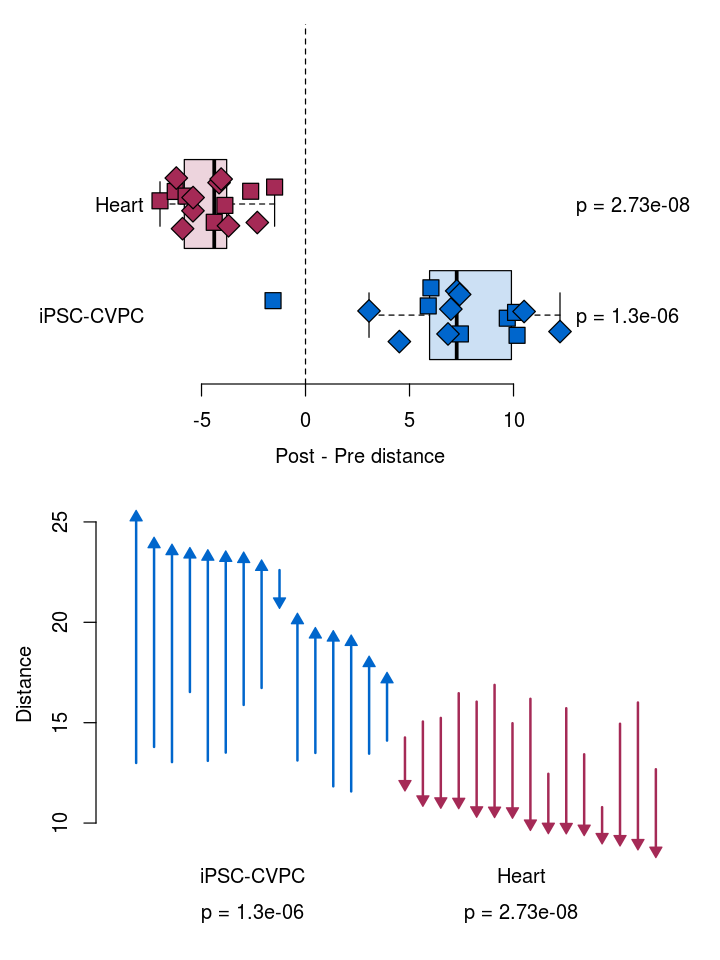

In [32]:
plot_hf2dist = function(hf2dist, metadata)
{
    tissues = sort(unique(metadata$tissue))
    tissues = c("ipsc_cvpc", "heart")
    
    tissue2p = data.frame(tissue = tissues, pval = 1)
    
    
    toplot_list = lapply(tissues, function(tissue)
    {
        meta1                = hf2dist[hf2dist$lvad_support == "pre-LVAD" , c("subject_id", paste("dist", tissue, sep = "."))]
        meta2                = hf2dist[hf2dist$lvad_support == "Post-LVAD", c("subject_id", paste("dist", tissue, sep = "."))]
        colnames(meta1)[[2]] = "pre"
        colnames(meta2)[[2]] = "post"
        totest               = merge(meta1, meta2, by = "subject_id", suffixes = c("_pre", "_post"))
        totest$tissue        = tissue
        test                 = t.test(totest$post, totest$pre, paired = TRUE)
        
        message(paste(tissue, mean(totest$pre), mean(totest$post), test$estimate, test$p.value))
        
        return(list(pval =  test$p.value, totest = totest))
    })

    toplot        = as.data.frame(rbindlist(lapply(toplot_list, function(x){x$totest})), stringsAsFactors = FALSE)
    tissue2p$pval = unlist(lapply(toplot_list, function(x){x$pval}))
    
    tissue2color3$order = c(3,1,2,4)
    tissue2color3       = tissue2color3[order(tissue2color3$order),]
    toplot              = merge(toplot, tissue2color3)
    toplot              = toplot[order(toplot$order),]
    toplot$distance     = toplot$post - toplot$pre
    toplot$pch          = 22
    toplot$y            = jitter(x = toplot$order, amount = 0.25)
    xlims               = range(toplot$distance)
    tissue2color3       = merge(unique(toplot[,c("tissue", "body_site", "order", "color")]), tissue2p)
    tissue2color3$ptext = paste("p", signif(tissue2color3$pval, digits = 3), sep = " = ")
    tissue2color3       = tissue2color3[order(tissue2color3$order),]
    
    toplot[grepl("NICM", toplot$subject_id) == TRUE, "pch"] = 23
    
    options(repr.plot.width = 6, repr.plot.height = 8)
    layout(cbind(1:2))
    
    par(mar = c(4,6,1,6))
    plot(1,1, type = "n", xlim = xlims, ylim = c(0.5, 3.5), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    mtext(text = tissue2color3$body_site, side = 2, line = 0  , at = tissue2color3$order, las = 2)
    mtext(text = tissue2color3$ptext    , side = 4, line = 0  , at = tissue2color3$order, las = 2)
    mtext(text = "Post - Pre distance"  , side = 1, line = 2.5)
    
    abline(v = 0, lty = "dashed")
    
    toplot$order2 = factor(toplot$tissue, levels = tissue2color3$tissue)
    boxplot(distance ~ order2, data = toplot, col = paste(tissue2color3$color, "33", sep = ""), add = TRUE, at = tissue2color3$order, outline = FALSE, axes = FALSE, horizontal = TRUE)
    
    #abline(a = 0, b = 1, lty = "dashed")
    points(x = toplot$distance, y = toplot$y, pch = toplot$pch, bg = toplot$col, cex = 2)
    
    toplot     = toplot[order(toplot$order, -toplot$post),]
    toplot$x   = 1:nrow(toplot)
    toplot$pch = 24
    xlims      = c(0, nrow(toplot) + 1)
    ylims      = range(as.numeric(as.matrix(toplot[,c("pre", "post")])))
    
    toplot[toplot$distance < 0, "pch"] = 25
    
    par(mar = c(4,4,1,1))
    plot(1,1, type = "n", xlim = xlims, ylim = ylims, xlab = "", ylab = "", axes = FALSE)
    axis(2)
    
    segments(x0 = toplot$x, y0 = toplot$pre , col = toplot$color, y1 = toplot$post , lwd = 2)
    points  (x  = toplot$x, y  = toplot$post, col = toplot$color, bg = toplot$color, pch = toplot$pch)
    
    tissue2color3 = merge(tissue2color3, aggregate(x ~ body_site, data = toplot, FUN = mean))
    
    
    mtext(text = tissue2color3$body_site, side = 1, line = 0  , at = tissue2color3$x - 0.5)
    mtext(text = tissue2color3$ptext    , side = 1, line = 1.5, at = tissue2color3$x - 0.5)
    mtext(text = "Distance"             , side = 2, line = 2.5)
}

plot_hf2dist(hf2dist, metadata)


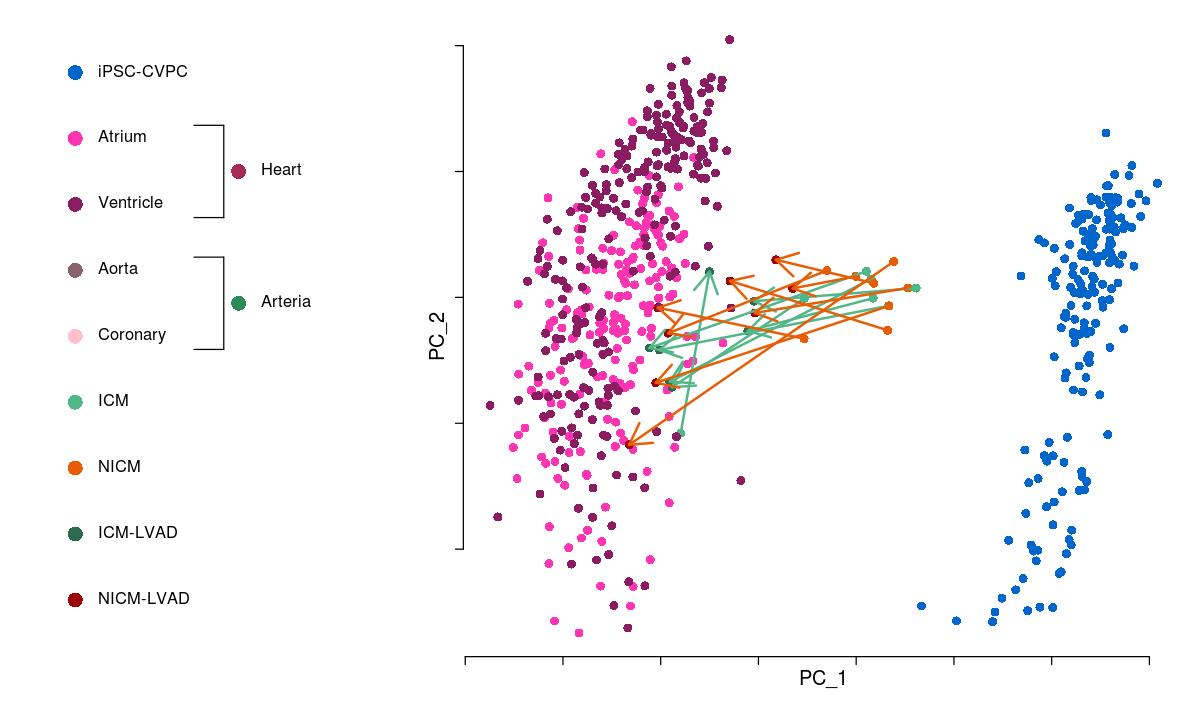

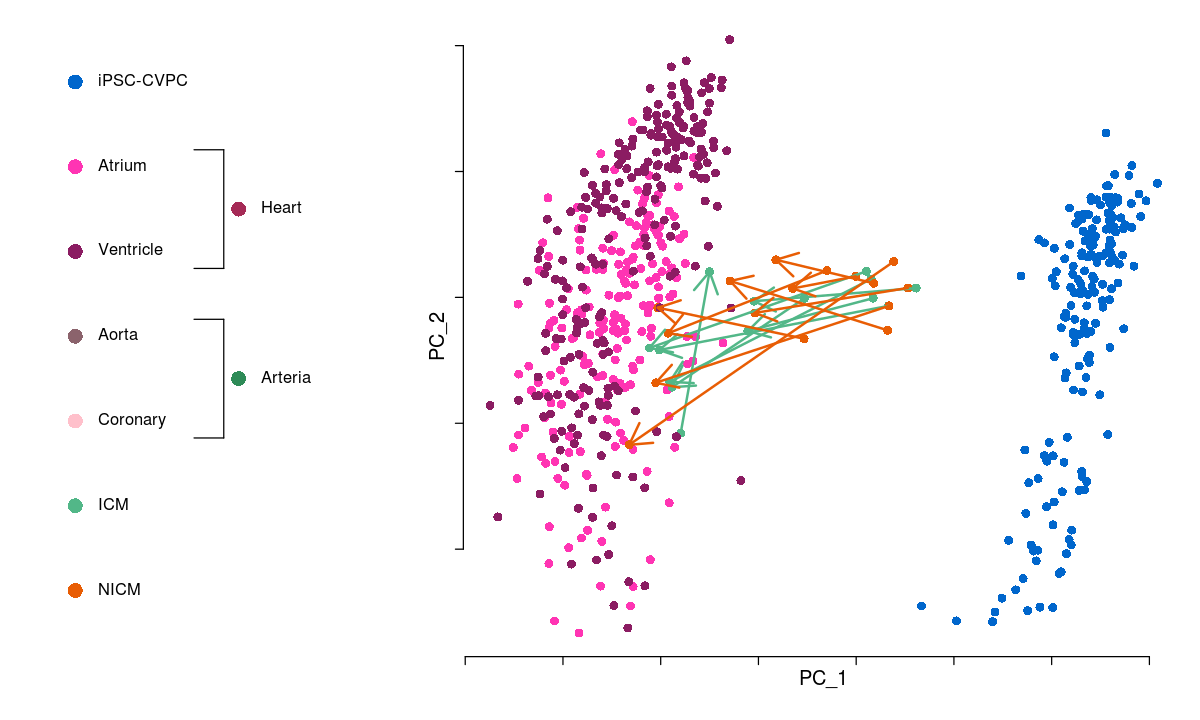

In [33]:
figure_umap = function(hf2dist, umap, x, colordata, umap1, umap2, panel = "", legend = FALSE)
{
    umap$run   = rownames(umap)
    umap       = merge(umap, colordata)
    umap$x     = umap[,x    ]
    umap$umap1 = umap[,umap1]
    umap$umap2 = umap[,umap2]
    hf2dist    = merge(hf2dist, umap[,c("run", "umap1", "umap2")], by = "run")
    
    par(mar = c(4,4,1,1))
    if(legend == TRUE)
    {
        plot(1,1, type = "n", xlim = c(0,1), ylim = c(nrow(colordata) + 0.5, 0.5), xlab = "", ylab = "", axes = FALSE)
        
        points(x = rep(0   , nrow(colordata)), y = 1:nrow(colordata), pch = 16, cex = 2.5, col = colordata$color)
        text  (x = rep(0.05, nrow(colordata)), y = 1:nrow(colordata), labels = colordata$body_site, pos = 4, cex = 1.25)
        
        segments(x0 = 0.5, y0 = 1.8, y1 = 3.2)
        segments(x0 = 0.5, y0 = 3.8, y1 = 5.2)
        segments(x0 = 0.4, y0 = c(1.8, 3.2, 3.8, 5.2), x1 = 0.5)
        
        colordata2 = tissue2color3[c("heart", "arteria"),]
        
        points(x = rep(0.55, nrow(colordata2)), y = c(2.5, 4.5), pch = 16, cex = 2.5, col = colordata2$color)
        text  (x = rep(0.6 , nrow(colordata2)), y = c(2.5, 4.5), labels = colordata2$body_site, pos = 4, cex = 1.25)
        
        mtext(text = panel   , side = 2, line = 2, at = 0.5, font = 2, cex = 1.5, las = 2)
    }
    
    plot(umap$umap1, umap$umap2, pch = 16, col = umap$color, cex = 1.5, xlab = "", ylab = "", axes = FALSE)
    
    axis(1, labels = NA)
    axis(2, labels = NA)
    
    mtext(text = umap1, side = 1, line = 1)
    mtext(text = umap2, side = 2, line = 1)
    
    if(legend == FALSE)
    {
        mtext(text = panel   , side = 2, line = 2, at = max(umap$umap2), font = 2, cex = 1.5, las = 2)
        totext = aggregate(list(umap1 = umap$umap1, umap2 = umap$umap2), by = list(x = umap$x, color_points = umap$color), FUN = mean)
        totext$color = "#ffffff"
        if(x == "res_0"   ){totext[totext$x == 1, "color"] = "#000000"}
        if(x == "res_0.01"){totext[totext$x == 1, "color"] = "#000000"}
        if(nrow(totext[totext$color_points == "#FFC0CB",]) > 0){totext[totext$color_points == "#FFC0CB", "color"] = "#000000"}
        text(x = totext$umap1, y = totext$umap2, labels = totext$x, cex = 1.5, col = totext$color)
    }
    
    toa = merge(hf2dist[ hf2dist$lvad_support == "pre-LVAD" , c("subject_id", "umap1", "umap2")],
                hf2dist[ hf2dist$lvad_support == "Post-LVAD", c("subject_id", "umap1", "umap2")],
                by = "subject_id", suffixes = 1:2
               )
    
    
    toa$color = "#000000"
    toa[grepl("^ICM" , toa$subject_id) == TRUE, "color"] = colordata[colordata$tissue %in% c("ischemic_pre"   , "ischemic"   ), "color"]
    toa[grepl("^NICM", toa$subject_id) == TRUE, "color"] = colordata[colordata$tissue %in% c("nonischemic_pre", "nonischemic"), "color"]
    
    arrows(x0 = toa$umap11, x1 = toa$umap12, y0 = toa$umap21, y1 = toa$umap22, col = toa$color, length = 0.2, lwd = 2)
}

color_s1        = data.frame(row.names = c("ischemic_pre", "nonischemic_pre", "ischemic_post", "nonischemic_post"), 
                            tissue     = c("ischemic_pre", "nonischemic_pre", "ischemic_post", "nonischemic_post"), 
                            body_site  = c("ICM"         , "NICM"           , "ICM-LVAD"     , "NICM-LVAD"       ),
                            color      = c("#52b788"     , "#e85d04"        , "#2d6a4f"      , "#9d0208"         ),
                            order      = 6:9
                           )

color_s2        = data.frame(row.names = c("ischemic", "nonischemic"), 
                            tissue     = c("ischemic", "nonischemic"), 
                            body_site  = c("ICM"     , "NICM"       ),
                            color      = c("#52b788" , "#e85d04"    ),
                            order      = 6:7
                           )

umap1                = pcdata[,c("body_site", "UMAP_1", "UMAP_2", paste("PC", 1:10, sep = "_"))]
colnames(umap1)[[1]] = "tissue"

umap2                = pcdata[,c("body_site", "UMAP_1", "UMAP_2", paste("PC", 1:10, sep = "_"))]
colnames(umap2)[[1]] = "tissue"
umap2$tissue         = gsub("_pre", "", gsub("_post", "", umap2$tissue))


colordata1           = rbind(tissue2color, color_s1)
colordata1$tissue    = gsub("arteria_", "", gsub("heart_", "", colordata1$tissue))
colordata2           = rbind(tissue2color, color_s2)
colordata2$tissue    = gsub("arteria_", "", gsub("heart_", "", colordata2$tissue))


options(repr.plot.width = 10, repr.plot.height = 6)
layout(rbind(c(1,2,2)))
figure_umap(hf2dist, umap1, "tissue", colordata1, "PC_1", "PC_2", panel = "", legend = TRUE)
figure_umap(hf2dist, umap2, "tissue", colordata2, "PC_1", "PC_2", panel = "", legend = TRUE)


# PCA on all genes
- like figure 1b, only RBPs and using all samples (also RBPs): try gene expression and isoform expression

In [34]:
library(Seurat)

In [36]:
#load("/home/jennifer/projects/cardiac_eqtls/4.Heart_Failure/heart_failure_integrated_allgenes_woutHealthy.robj") # no healthy samples
#load("/home/jennifer/projects/cardiac_eqtls/4.Heart_Failure/heart_failure_integrated_allgenes_withHealthy.robj") # also healthy samples, need to add them
load("/home/jennifer/projects/cardiac_eqtls/4.Heart_Failure/results/heart_failure.heart_cvpc.all_genes.robj") # also healthy samples, need to add them
# isoforms

In [37]:
pcdata = integrated@meta.data


In [38]:
alldist = as.matrix(dist(as.matrix(pcdata[, paste("PC", 1:10, sep = "_")]), method = "euclidean"))

## Distance from iPSC-CVPCs and adult

In [39]:
calculate_mean_distance = function(x, id, metadata, alldist)
{
    ids    = metadata[metadata$tissue == x, "run"]
    mydist = as.numeric(alldist[ids, id])
    
    return(median(mydist))
}

hf2dist           = meta4[ meta4$lvad_support != "nil",]
rownames(hf2dist) = hf2dist$run

id = rownames(hf2dist)[[1]]
x = "ipsc_cvpc"

for(tissue in sort(unique(metadata$tissue)))
{
    hf2dist[, paste("dist", tissue, sep = ".")] = unlist(lapply(rownames(hf2dist), function(id){calculate_mean_distance(tissue, id, metadata, alldist)}))
}


fwrite(hf2dist, "pipeline/4.13.heart_failure/hf2dist_all_genes.txt", sep = "\t", col.names = TRUE, row.names = FALSE)
fwrite(pcdata , "pipeline/4.13.heart_failure/pcdata_all_genes.txt" , sep = "\t", col.names = TRUE, row.names = TRUE )


In [40]:
hf2dist

,run,name,age,sex,lvad_support,subject_id,dist.heart,dist.ipsc_cvpc
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>
SRR830989,SRR830989,ICM_LVAD1,54,male,Post-LVAD,ICM1,60.57287,173.6004
SRR830990,SRR830990,ICM_LVAD2,55,male,Post-LVAD,ICM2,65.97902,172.3780
SRR830991,SRR830991,ICM_LVAD3,63,male,Post-LVAD,ICM3,68.47115,155.3003
SRR830993,SRR830993,ICM_LVAD5,65,male,Post-LVAD,ICM5,63.97176,175.9630
SRR830994,SRR830994,ICM_LVAD6,67,male,Post-LVAD,ICM6,58.81135,178.4181
SRR830995,SRR830995,ICM_LVAD7,62,male,Post-LVAD,ICM7,62.67788,169.9676
SRR830996,SRR830996,ICM_LVAD8,66,male,Post-LVAD,ICM8,68.56814,157.8719
SRR830973,SRR830973,ICM1,54,male,pre-LVAD,ICM1,64.52627,168.0754
SRR830974,SRR830974,ICM2,55,male,pre-LVAD,ICM2,65.23627,158.0532


In [41]:
source("script/colors.R"    )


heart 70.2637690436384 69.3411087429115 -0.922660300726911 0.777148820436063

ipsc_cvpc 153.989548864099 159.822368574718 5.83281971061838 0.248622736206994



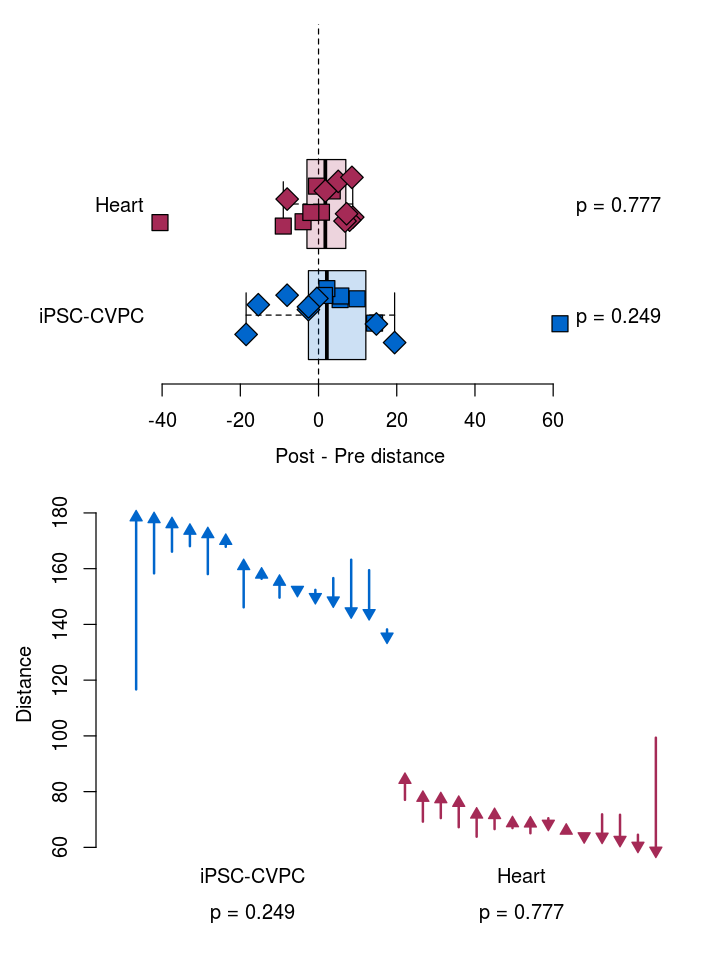

In [42]:
plot_hf2dist = function(hf2dist, metadata)
{
    tissues = sort(unique(metadata$tissue))
    
    tissue2p = data.frame(tissue = tissues, pval = 1)
    
    
    toplot_list = lapply(tissues, function(tissue)
    {
        meta1                = hf2dist[hf2dist$lvad_support == "pre-LVAD" , c("subject_id", paste("dist", tissue, sep = "."))]
        meta2                = hf2dist[hf2dist$lvad_support == "Post-LVAD", c("subject_id", paste("dist", tissue, sep = "."))]
        colnames(meta1)[[2]] = "pre"
        colnames(meta2)[[2]] = "post"
        totest               = merge(meta1, meta2, by = "subject_id", suffixes = c("_pre", "_post"))
        totest$tissue        = tissue
        test                 = t.test(totest$post, totest$pre, paired = TRUE)
        
        message(paste(tissue, mean(totest$pre), mean(totest$post), test$estimate, test$p.value))
        
        return(list(pval =  test$p.value, totest = totest))
    })

    toplot        = as.data.frame(rbindlist(lapply(toplot_list, function(x){x$totest})), stringsAsFactors = FALSE)
    tissue2p$pval = unlist(lapply(toplot_list, function(x){x$pval}))
    
    tissue2color3$order = c(3,1,2,4)
    tissue2color3       = tissue2color3[order(tissue2color3$order),]
    toplot              = merge(toplot, tissue2color3)
    toplot              = toplot[order(toplot$order),]
    toplot$distance     = toplot$post - toplot$pre
    toplot$pch          = 22
    toplot$y            = jitter(x = toplot$order, amount = 0.25)
    xlims               = range(toplot$distance)
    tissue2color3       = merge(unique(toplot[,c("tissue", "body_site", "order", "color")]), tissue2p)
    tissue2color3$ptext = paste("p", signif(tissue2color3$pval, digits = 3), sep = " = ")
    tissue2color3       = tissue2color3[order(tissue2color3$order),]
    
    toplot[grepl("NICM", toplot$subject_id) == TRUE, "pch"] = 23
    
    options(repr.plot.width = 6, repr.plot.height = 8)
    layout(cbind(1:2))
    
    par(mar = c(4,6,1,6))
    plot(1,1, type = "n", xlim = xlims, ylim = c(0.5, 3.5), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    mtext(text = tissue2color3$body_site, side = 2, line = 0  , at = tissue2color3$order, las = 2)
    mtext(text = tissue2color3$ptext    , side = 4, line = 0  , at = tissue2color3$order, las = 2)
    mtext(text = "Post - Pre distance"  , side = 1, line = 2.5)
    
    abline(v = 0, lty = "dashed")
    
    toplot$order2 = factor(toplot$tissue, levels = tissue2color3$tissue)
    boxplot(distance ~ order2, data = toplot, col = paste(tissue2color3$color, "33", sep = ""), add = TRUE, at = tissue2color3$order, outline = FALSE, axes = FALSE, horizontal = TRUE)
    
    #abline(a = 0, b = 1, lty = "dashed")
    points(x = toplot$distance, y = toplot$y, pch = toplot$pch, bg = toplot$col, cex = 2)
    
    toplot     = toplot[order(toplot$order, -toplot$post),]
    toplot$x   = 1:nrow(toplot)
    toplot$pch = 24
    xlims      = c(0, nrow(toplot) + 1)
    ylims      = range(as.numeric(as.matrix(toplot[,c("pre", "post")])))
    
    toplot[toplot$distance < 0, "pch"] = 25
    
    par(mar = c(4,4,1,1))
    plot(1,1, type = "n", xlim = xlims, ylim = ylims, xlab = "", ylab = "", axes = FALSE)
    axis(2)
    
    segments(x0 = toplot$x, y0 = toplot$pre , col = toplot$color, y1 = toplot$post , lwd = 2)
    points  (x  = toplot$x, y  = toplot$post, col = toplot$color, bg = toplot$color, pch = toplot$pch)
    
    tissue2color3 = merge(tissue2color3, aggregate(x ~ body_site, data = toplot, FUN = mean))
    
    
    mtext(text = tissue2color3$body_site, side = 1, line = 0  , at = tissue2color3$x - 0.5)
    mtext(text = tissue2color3$ptext    , side = 1, line = 1.5, at = tissue2color3$x - 0.5)
    mtext(text = "Distance"             , side = 2, line = 2.5)
}

plot_hf2dist(hf2dist, metadata)


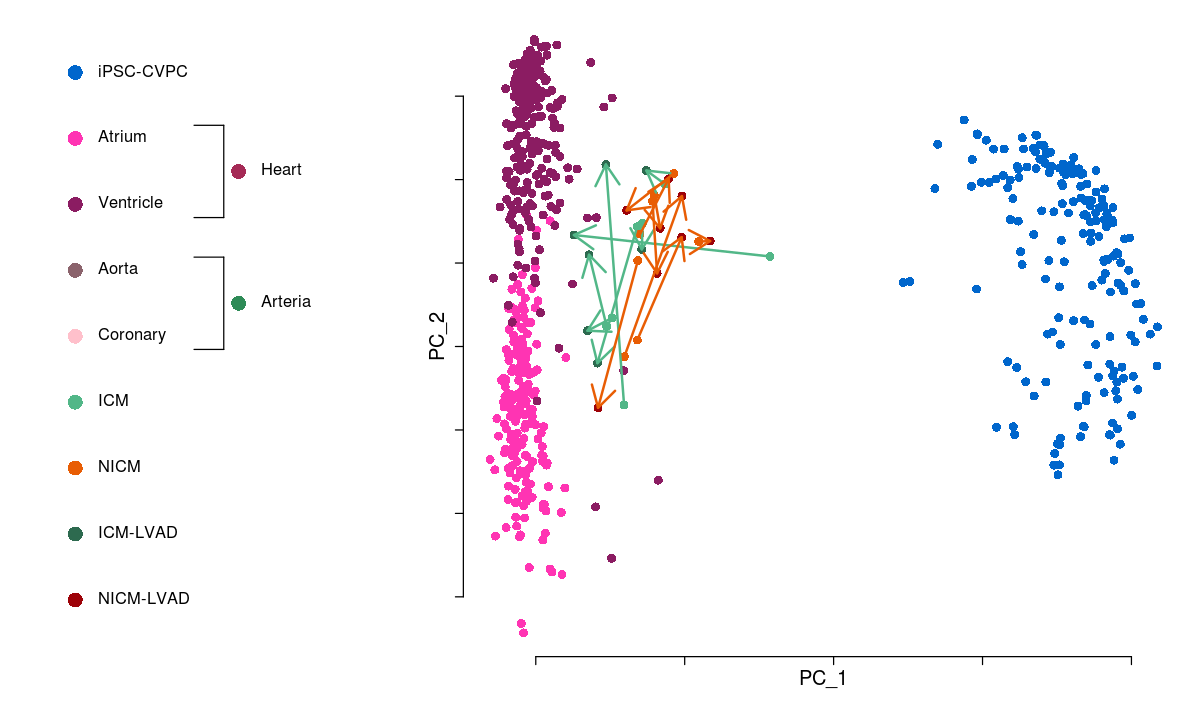

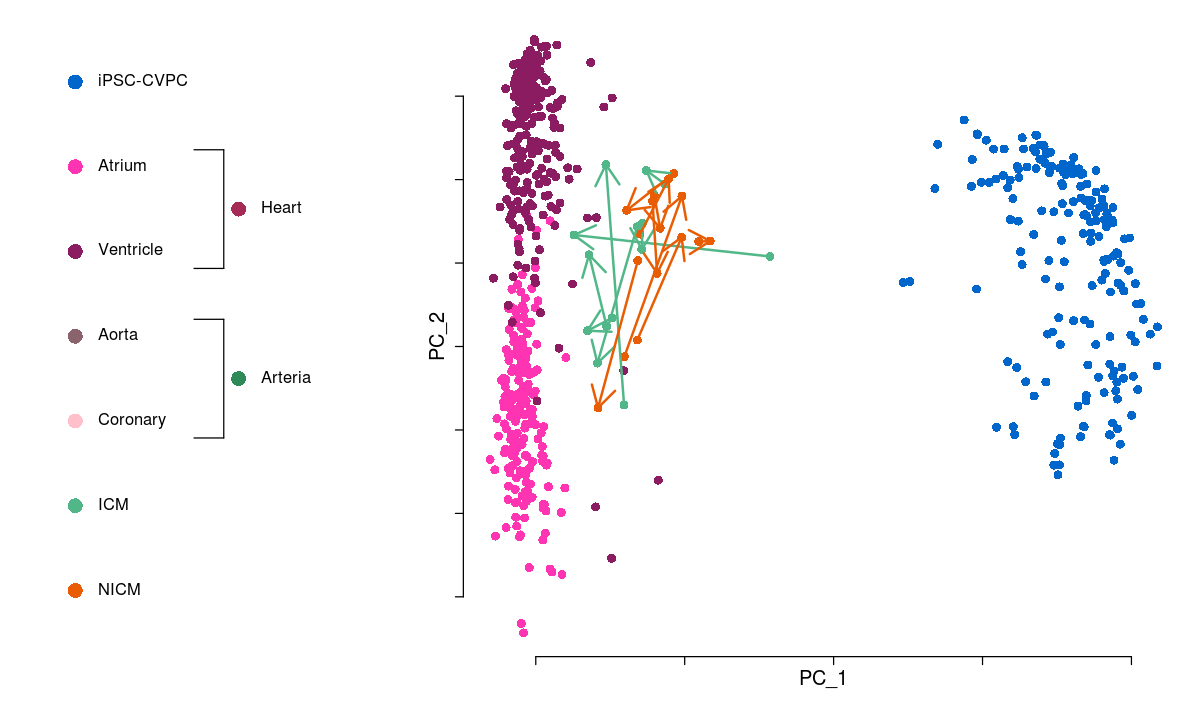

In [43]:
figure_umap = function(hf2dist, umap, x, colordata, umap1, umap2, panel = "", legend = FALSE)
{
    umap$run   = rownames(umap)
    umap       = merge(umap, colordata)
    umap$x     = umap[,x    ]
    umap$umap1 = umap[,umap1]
    umap$umap2 = umap[,umap2]
    hf2dist    = merge(hf2dist, umap[,c("run", "umap1", "umap2")], by = "run")
    
    par(mar = c(4,4,1,1))
    if(legend == TRUE)
    {
        plot(1,1, type = "n", xlim = c(0,1), ylim = c(nrow(colordata) + 0.5, 0.5), xlab = "", ylab = "", axes = FALSE)
        
        points(x = rep(0   , nrow(colordata)), y = 1:nrow(colordata), pch = 16, cex = 2.5, col = colordata$color)
        text  (x = rep(0.05, nrow(colordata)), y = 1:nrow(colordata), labels = colordata$body_site, pos = 4, cex = 1.25)
        
        segments(x0 = 0.5, y0 = 1.8, y1 = 3.2)
        segments(x0 = 0.5, y0 = 3.8, y1 = 5.2)
        segments(x0 = 0.4, y0 = c(1.8, 3.2, 3.8, 5.2), x1 = 0.5)
        
        colordata2 = tissue2color3[c("heart", "arteria"),]
        
        points(x = rep(0.55, nrow(colordata2)), y = c(2.5, 4.5), pch = 16, cex = 2.5, col = colordata2$color)
        text  (x = rep(0.6 , nrow(colordata2)), y = c(2.5, 4.5), labels = colordata2$body_site, pos = 4, cex = 1.25)
        
        mtext(text = panel   , side = 2, line = 2, at = 0.5, font = 2, cex = 1.5, las = 2)
    }
    
    plot(umap$umap1, umap$umap2, pch = 16, col = umap$color, cex = 1.5, xlab = "", ylab = "", axes = FALSE)
    
    axis(1, labels = NA)
    axis(2, labels = NA)
    
    mtext(text = umap1, side = 1, line = 1)
    mtext(text = umap2, side = 2, line = 1)
    
    if(legend == FALSE)
    {
        mtext(text = panel   , side = 2, line = 2, at = max(umap$umap2), font = 2, cex = 1.5, las = 2)
        totext = aggregate(list(umap1 = umap$umap1, umap2 = umap$umap2), by = list(x = umap$x, color_points = umap$color), FUN = mean)
        totext$color = "#ffffff"
        if(x == "res_0"   ){totext[totext$x == 1, "color"] = "#000000"}
        if(x == "res_0.01"){totext[totext$x == 1, "color"] = "#000000"}
        if(nrow(totext[totext$color_points == "#FFC0CB",]) > 0){totext[totext$color_points == "#FFC0CB", "color"] = "#000000"}
        text(x = totext$umap1, y = totext$umap2, labels = totext$x, cex = 1.5, col = totext$color)
    }
    
    toa = merge(hf2dist[ hf2dist$lvad_support == "pre-LVAD" , c("subject_id", "umap1", "umap2")],
                hf2dist[ hf2dist$lvad_support == "Post-LVAD", c("subject_id", "umap1", "umap2")],
                by = "subject_id", suffixes = 1:2
               )
    
    
    toa$color = "#000000"
    toa[grepl("^ICM" , toa$subject_id) == TRUE, "color"] = colordata[colordata$tissue %in% c("ischemic_pre"   , "ischemic"   ), "color"]
    toa[grepl("^NICM", toa$subject_id) == TRUE, "color"] = colordata[colordata$tissue %in% c("nonischemic_pre", "nonischemic"), "color"]
    
    arrows(x0 = toa$umap11, x1 = toa$umap12, y0 = toa$umap21, y1 = toa$umap22, col = toa$color, length = 0.2, lwd = 2)
}

color_s1        = data.frame(row.names = c("ischemic_pre", "nonischemic_pre", "ischemic_post", "nonischemic_post"), 
                            tissue     = c("ischemic_pre", "nonischemic_pre", "ischemic_post", "nonischemic_post"), 
                            body_site  = c("ICM"         , "NICM"           , "ICM-LVAD"     , "NICM-LVAD"       ),
                            color      = c("#52b788"     , "#e85d04"        , "#2d6a4f"      , "#9d0208"         ),
                            order      = 6:9
                           )

color_s2        = data.frame(row.names = c("ischemic", "nonischemic"), 
                            tissue     = c("ischemic", "nonischemic"), 
                            body_site  = c("ICM"     , "NICM"       ),
                            color      = c("#52b788" , "#e85d04"    ),
                            order      = 6:7
                           )

umap1                = pcdata[,c("body_site", "UMAP_1", "UMAP_2", paste("PC", 1:10, sep = "_"))]
colnames(umap1)[[1]] = "tissue"

umap2                = pcdata[,c("body_site", "UMAP_1", "UMAP_2", paste("PC", 1:10, sep = "_"))]
colnames(umap2)[[1]] = "tissue"
umap2$tissue         = gsub("_pre", "", gsub("_post", "", umap2$tissue))


colordata1           = rbind(tissue2color, color_s1)
colordata1$tissue    = gsub("arteria_", "", gsub("heart_", "", colordata1$tissue))
colordata2           = rbind(tissue2color, color_s2)
colordata2$tissue    = gsub("arteria_", "", gsub("heart_", "", colordata2$tissue))


options(repr.plot.width = 10, repr.plot.height = 6)
layout(rbind(c(1,2,2)))
figure_umap(hf2dist, umap1, "tissue", colordata1, "PC_1", "PC_2", panel = "", legend = TRUE)
figure_umap(hf2dist, umap2, "tissue", colordata2, "PC_1", "PC_2", panel = "", legend = TRUE)


# PCA on one isoform (the most variable) per gene
- like figure 1b, only RBPs and using all samples (also RBPs): try gene expression and isoform expression

In [387]:
library(Seurat)

In [52]:
#load("/home/jennifer/projects/cardiac_eqtls/4.Heart_Failure/heart_failure_integrated_allgenes_woutHealthy.robj") # no healthy samples
load("/frazer01/home/jennifer/projects/cardiac_eqtls/4.Heart_Failure/results/isoforms.heart_failure_integrated_SD.robj") # also healthy samples, need to add them
load("/frazer01/home/jennifer/projects/cardiac_eqtls/4.Heart_Failure/integrated.allisoforms.gt15_lt90.heart_failure.robj") # also healthy samples, need to add them
load("/frazer01/home/jennifer/projects/cardiac_eqtls/4.Heart_Failure/results/heart_failure.heart_cvpc.all_isoforms.robj") # also healthy samples, need to add them

# isoforms

In [53]:
pcdata = integrated@meta.data


In [54]:
alldist = as.matrix(dist(as.matrix(pcdata[, paste("PC", 1:10, sep = "_")]), method = "euclidean"))

## Distance from iPSC-CVPCs and adult

In [55]:
calculate_mean_distance = function(x, id, metadata, alldist)
{
    ids    = metadata[metadata$tissue == x, "run"]
    mydist = as.numeric(alldist[ids, id])
    
    return(median(mydist))
}

hf2dist           = meta4[ meta4$lvad_support != "nil",]
rownames(hf2dist) = hf2dist$run

id = rownames(hf2dist)[[1]]
x = "ipsc_cvpc"

for(tissue in sort(unique(metadata$tissue)))
{
    hf2dist[, paste("dist", tissue, sep = ".")] = unlist(lapply(rownames(hf2dist), function(id){calculate_mean_distance(tissue, id, metadata, alldist)}))
}


fwrite(hf2dist, "pipeline/4.13.heart_failure/hf2dist_all_isoforms.txt", sep = "\t", col.names = TRUE, row.names = FALSE)
fwrite(pcdata , "pipeline/4.13.heart_failure/pcdata_all_isoforms.txt" , sep = "\t", col.names = TRUE, row.names = TRUE )


In [56]:
hf2dist

,run,name,age,sex,lvad_support,subject_id,dist.heart,dist.ipsc_cvpc
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>
SRR830989,SRR830989,ICM_LVAD1,54,male,Post-LVAD,ICM1,48.35269,139.50405
SRR830990,SRR830990,ICM_LVAD2,55,male,Post-LVAD,ICM2,55.46217,109.12883
SRR830991,SRR830991,ICM_LVAD3,63,male,Post-LVAD,ICM3,61.53501,110.44173
SRR830993,SRR830993,ICM_LVAD5,65,male,Post-LVAD,ICM5,51.27863,138.09938
SRR830994,SRR830994,ICM_LVAD6,67,male,Post-LVAD,ICM6,49.41856,137.99832
SRR830995,SRR830995,ICM_LVAD7,62,male,Post-LVAD,ICM7,51.82607,115.27972
SRR830996,SRR830996,ICM_LVAD8,66,male,Post-LVAD,ICM8,61.03646,98.26053
SRR830973,SRR830973,ICM1,54,male,pre-LVAD,ICM1,63.42639,96.90341
SRR830974,SRR830974,ICM2,55,male,pre-LVAD,ICM2,63.90428,96.18562


In [57]:
source("script/colors.R"    )


heart 67.9987676541873 63.1315282959829 -4.86723935820439 0.0805602493398787

ipsc_cvpc 92.9844033664066 104.258336254035 11.2739328876288 0.0335095174176396



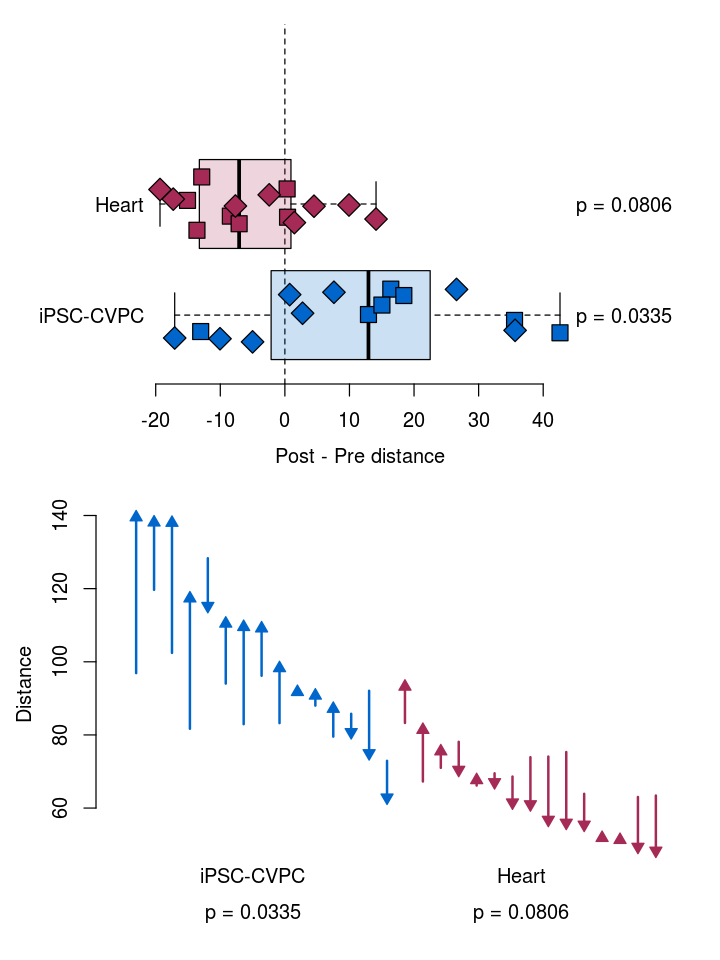

In [58]:
plot_hf2dist = function(hf2dist, metadata)
{
    tissues = sort(unique(metadata$tissue))
    
    tissue2p = data.frame(tissue = tissues, pval = 1)
    
    
    toplot_list = lapply(tissues, function(tissue)
    {
        meta1                = hf2dist[hf2dist$lvad_support == "pre-LVAD" , c("subject_id", paste("dist", tissue, sep = "."))]
        meta2                = hf2dist[hf2dist$lvad_support == "Post-LVAD", c("subject_id", paste("dist", tissue, sep = "."))]
        colnames(meta1)[[2]] = "pre"
        colnames(meta2)[[2]] = "post"
        totest               = merge(meta1, meta2, by = "subject_id", suffixes = c("_pre", "_post"))
        totest$tissue        = tissue
        test                 = t.test(totest$post, totest$pre, paired = TRUE)
        
        message(paste(tissue, mean(totest$pre), mean(totest$post), test$estimate, test$p.value))
        
        return(list(pval =  test$p.value, totest = totest))
    })

    toplot        = as.data.frame(rbindlist(lapply(toplot_list, function(x){x$totest})), stringsAsFactors = FALSE)
    tissue2p$pval = unlist(lapply(toplot_list, function(x){x$pval}))
    
    tissue2color3$order = c(3,1,2,4)
    tissue2color3       = tissue2color3[order(tissue2color3$order),]
    toplot              = merge(toplot, tissue2color3)
    toplot              = toplot[order(toplot$order),]
    toplot$distance     = toplot$post - toplot$pre
    toplot$pch          = 22
    toplot$y            = jitter(x = toplot$order, amount = 0.25)
    xlims               = range(toplot$distance)
    tissue2color3       = merge(unique(toplot[,c("tissue", "body_site", "order", "color")]), tissue2p)
    tissue2color3$ptext = paste("p", signif(tissue2color3$pval, digits = 3), sep = " = ")
    tissue2color3       = tissue2color3[order(tissue2color3$order),]
    
    toplot[grepl("NICM", toplot$subject_id) == TRUE, "pch"] = 23
    
    options(repr.plot.width = 6, repr.plot.height = 8)
    layout(cbind(1:2))
    
    par(mar = c(4,6,1,6))
    plot(1,1, type = "n", xlim = xlims, ylim = c(0.5, 3.5), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    mtext(text = tissue2color3$body_site, side = 2, line = 0  , at = tissue2color3$order, las = 2)
    mtext(text = tissue2color3$ptext    , side = 4, line = 0  , at = tissue2color3$order, las = 2)
    mtext(text = "Post - Pre distance"  , side = 1, line = 2.5)
    
    abline(v = 0, lty = "dashed")
    
    toplot$order2 = factor(toplot$tissue, levels = tissue2color3$tissue)
    boxplot(distance ~ order2, data = toplot, col = paste(tissue2color3$color, "33", sep = ""), add = TRUE, at = tissue2color3$order, outline = FALSE, axes = FALSE, horizontal = TRUE)
    
    #abline(a = 0, b = 1, lty = "dashed")
    points(x = toplot$distance, y = toplot$y, pch = toplot$pch, bg = toplot$col, cex = 2)
    
    toplot     = toplot[order(toplot$order, -toplot$post),]
    toplot$x   = 1:nrow(toplot)
    toplot$pch = 24
    xlims      = c(0, nrow(toplot) + 1)
    ylims      = range(as.numeric(as.matrix(toplot[,c("pre", "post")])))
    
    toplot[toplot$distance < 0, "pch"] = 25
    
    par(mar = c(4,4,1,1))
    plot(1,1, type = "n", xlim = xlims, ylim = ylims, xlab = "", ylab = "", axes = FALSE)
    axis(2)
    
    segments(x0 = toplot$x, y0 = toplot$pre , col = toplot$color, y1 = toplot$post , lwd = 2)
    points  (x  = toplot$x, y  = toplot$post, col = toplot$color, bg = toplot$color, pch = toplot$pch)
    
    tissue2color3 = merge(tissue2color3, aggregate(x ~ body_site, data = toplot, FUN = mean))
    
    
    mtext(text = tissue2color3$body_site, side = 1, line = 0  , at = tissue2color3$x - 0.5)
    mtext(text = tissue2color3$ptext    , side = 1, line = 1.5, at = tissue2color3$x - 0.5)
    mtext(text = "Distance"             , side = 2, line = 2.5)
}

plot_hf2dist(hf2dist, metadata)


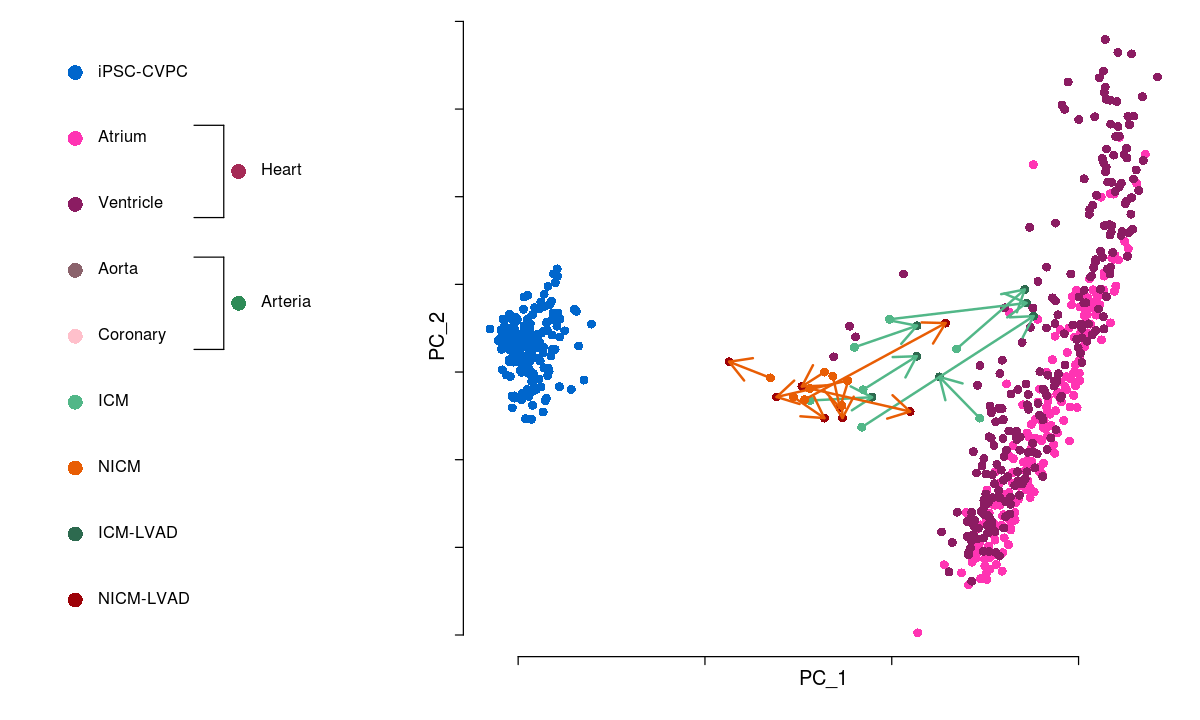

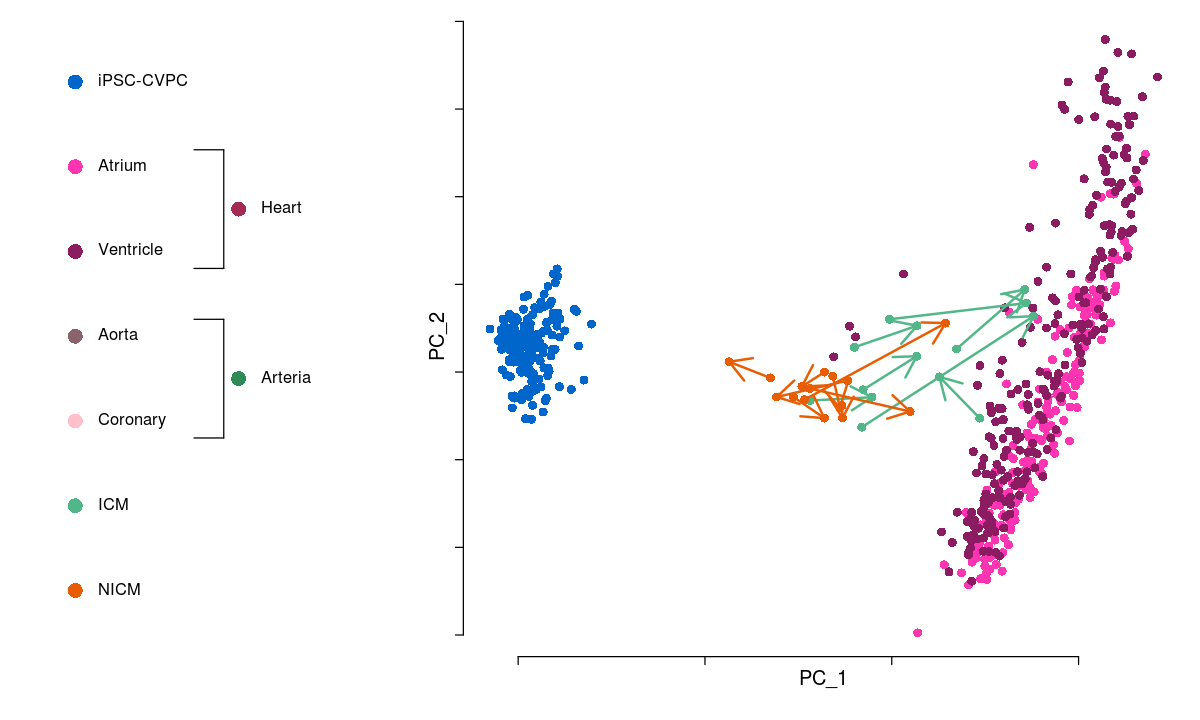

In [59]:
figure_umap = function(hf2dist, umap, x, colordata, umap1, umap2, panel = "", legend = FALSE)
{
    umap$run   = rownames(umap)
    umap       = merge(umap, colordata)
    umap$x     = umap[,x    ]
    umap$umap1 = umap[,umap1]
    umap$umap2 = umap[,umap2]
    hf2dist    = merge(hf2dist, umap[,c("run", "umap1", "umap2")], by = "run")
    
    par(mar = c(4,4,1,1))
    if(legend == TRUE)
    {
        plot(1,1, type = "n", xlim = c(0,1), ylim = c(nrow(colordata) + 0.5, 0.5), xlab = "", ylab = "", axes = FALSE)
        
        points(x = rep(0   , nrow(colordata)), y = 1:nrow(colordata), pch = 16, cex = 2.5, col = colordata$color)
        text  (x = rep(0.05, nrow(colordata)), y = 1:nrow(colordata), labels = colordata$body_site, pos = 4, cex = 1.25)
        
        segments(x0 = 0.5, y0 = 1.8, y1 = 3.2)
        segments(x0 = 0.5, y0 = 3.8, y1 = 5.2)
        segments(x0 = 0.4, y0 = c(1.8, 3.2, 3.8, 5.2), x1 = 0.5)
        
        colordata2 = tissue2color3[c("heart", "arteria"),]
        
        points(x = rep(0.55, nrow(colordata2)), y = c(2.5, 4.5), pch = 16, cex = 2.5, col = colordata2$color)
        text  (x = rep(0.6 , nrow(colordata2)), y = c(2.5, 4.5), labels = colordata2$body_site, pos = 4, cex = 1.25)
        
        mtext(text = panel   , side = 2, line = 2, at = 0.5, font = 2, cex = 1.5, las = 2)
    }
    
    plot(umap$umap1, umap$umap2, pch = 16, col = umap$color, cex = 1.5, xlab = "", ylab = "", axes = FALSE)
    
    axis(1, labels = NA)
    axis(2, labels = NA)
    
    mtext(text = umap1, side = 1, line = 1)
    mtext(text = umap2, side = 2, line = 1)
    
    if(legend == FALSE)
    {
        mtext(text = panel   , side = 2, line = 2, at = max(umap$umap2), font = 2, cex = 1.5, las = 2)
        totext = aggregate(list(umap1 = umap$umap1, umap2 = umap$umap2), by = list(x = umap$x, color_points = umap$color), FUN = mean)
        totext$color = "#ffffff"
        if(x == "res_0"   ){totext[totext$x == 1, "color"] = "#000000"}
        if(x == "res_0.01"){totext[totext$x == 1, "color"] = "#000000"}
        if(nrow(totext[totext$color_points == "#FFC0CB",]) > 0){totext[totext$color_points == "#FFC0CB", "color"] = "#000000"}
        text(x = totext$umap1, y = totext$umap2, labels = totext$x, cex = 1.5, col = totext$color)
    }
    
    toa = merge(hf2dist[ hf2dist$lvad_support == "pre-LVAD" , c("subject_id", "umap1", "umap2")],
                hf2dist[ hf2dist$lvad_support == "Post-LVAD", c("subject_id", "umap1", "umap2")],
                by = "subject_id", suffixes = 1:2
               )
    
    
    toa$color = "#000000"
    toa[grepl("^ICM" , toa$subject_id) == TRUE, "color"] = colordata[colordata$tissue %in% c("ischemic_pre"   , "ischemic"   ), "color"]
    toa[grepl("^NICM", toa$subject_id) == TRUE, "color"] = colordata[colordata$tissue %in% c("nonischemic_pre", "nonischemic"), "color"]
    
    arrows(x0 = toa$umap11, x1 = toa$umap12, y0 = toa$umap21, y1 = toa$umap22, col = toa$color, length = 0.2, lwd = 2)
}

color_s1        = data.frame(row.names = c("ischemic_pre", "nonischemic_pre", "ischemic_post", "nonischemic_post"), 
                            tissue     = c("ischemic_pre", "nonischemic_pre", "ischemic_post", "nonischemic_post"), 
                            body_site  = c("ICM"         , "NICM"           , "ICM-LVAD"     , "NICM-LVAD"       ),
                            color      = c("#52b788"     , "#e85d04"        , "#2d6a4f"      , "#9d0208"         ),
                            order      = 6:9
                           )

color_s2        = data.frame(row.names = c("ischemic", "nonischemic"), 
                            tissue     = c("ischemic", "nonischemic"), 
                            body_site  = c("ICM"     , "NICM"       ),
                            color      = c("#52b788" , "#e85d04"    ),
                            order      = 6:7
                           )

umap1                = pcdata[,c("body_site", "UMAP_1", "UMAP_2", paste("PC", 1:10, sep = "_"))]
colnames(umap1)[[1]] = "tissue"

umap2                = pcdata[,c("body_site", "UMAP_1", "UMAP_2", paste("PC", 1:10, sep = "_"))]
colnames(umap2)[[1]] = "tissue"
umap2$tissue         = gsub("_pre", "", gsub("_post", "", umap2$tissue))


colordata1           = rbind(tissue2color, color_s1)
colordata1$tissue    = gsub("arteria_", "", gsub("heart_", "", colordata1$tissue))
colordata2           = rbind(tissue2color, color_s2)
colordata2$tissue    = gsub("arteria_", "", gsub("heart_", "", colordata2$tissue))


options(repr.plot.width = 10, repr.plot.height = 6)
layout(rbind(c(1,2,2)))
figure_umap(hf2dist, umap1, "tissue", colordata1, "PC_1", "PC_2", panel = "", legend = TRUE)
figure_umap(hf2dist, umap2, "tissue", colordata2, "PC_1", "PC_2", panel = "", legend = TRUE)


# Deconvolution heart failure

In [445]:
meta4

,run,name,age,sex,lvad_support,subject_id
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
1,SRR830989,ICM_LVAD1,54,male,Post-LVAD,ICM1
2,SRR830990,ICM_LVAD2,55,male,Post-LVAD,ICM2
3,SRR830991,ICM_LVAD3,63,male,Post-LVAD,ICM3
5,SRR830993,ICM_LVAD5,65,male,Post-LVAD,ICM5
6,SRR830994,ICM_LVAD6,67,male,Post-LVAD,ICM6
7,SRR830995,ICM_LVAD7,62,male,Post-LVAD,ICM7
8,SRR830996,ICM_LVAD8,66,male,Post-LVAD,ICM8
9,SRR830973,ICM1,54,male,pre-LVAD,ICM1
10,SRR830974,ICM2,55,male,pre-LVAD,ICM2
